In [38]:
import pandas as pd
import os

In [39]:
icu_data_path='mimic-iv-3.1/icu/icustays.csv.gz'
input_events_data_path='mimic-iv-3.1/icu/inputevents.csv.gz'
hosp_admissions = 'mimic-iv-3.1/hosp/admissions.csv.gz'
diag_desc = 'mimic-iv-3.1/hosp/d_icd_diagnoses.csv.gz'

In [40]:
icustays = pd.read_csv(icu_data_path, compression ='gzip')
icu_patients_data_path = 'mimic-iv-3.1/hosp/patients.csv.gz'

In [41]:
diagnoses  = pd.read_csv('mimic-iv-3.1/hosp/diagnoses_icd.csv.gz', compression ='gzip')

In [42]:
icustays['subject_id'].nunique()

65366

In [43]:
icustays

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
...,...,...,...,...,...,...,...,...
94453,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
94454,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
94455,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
94456,19999840,21033226,38978960,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


In [44]:
group_col='subject_id'
visit_col='stay_id'
admit_col='intime'
disch_col='outtime'
death_col='dod'
adm_visit_col='hadm_id'
use_mort=True,
use_los=False
los=0
use_admn=True
disease_label=""
use_ICU=True

In [45]:
def get_visit_pts(group_col:str, visit_col:str, admit_col:str, disch_col:str, adm_visit_col:str, use_mort:bool, use_los:bool, los:int, use_admn:bool, disease_label:str,use_ICU:bool):
    visit = pd.read_csv(icu_data_path, compression='gzip', header=0, index_col=None, parse_dates=[admit_col, disch_col])
    pts = pd.read_csv(
        icu_patients_data_path,
        compression='gzip',
        header=0,
        index_col = None,
        usecols=[group_col, 'anchor_year', 'anchor_age', 'anchor_year_group', 'dod','gender']
    )
    pts['yob']= pts['anchor_year'] - pts['anchor_age']  # get yob to ensure a given visit is from an adult
    pts['min_valid_year'] = pts['anchor_year'] + (2024 - pts['anchor_year_group'].str.slice(start=-4).astype(int))
    visit_pts = visit[[group_col, visit_col, adm_visit_col, admit_col, disch_col,'los','first_careunit','last_careunit']].merge(
        pts[[group_col, 'anchor_year', 'anchor_age', 'yob', 'min_valid_year', 'dod','gender']], how='inner', left_on=group_col, right_on=group_col)
    visit_pts['Age']=visit_pts['anchor_age']
    visit_pts = visit_pts.loc[(visit_pts['Age'] >= 18)]
    ##Add Demo data
    eth = pd.read_csv(hosp_admissions, compression='gzip', header=0, usecols=['hadm_id', 'insurance','race','marital_status','admission_type'], index_col=None)
    visit_pts= visit_pts.merge(eth, how='inner', left_on='hadm_id', right_on='hadm_id')
    return visit_pts[[group_col, visit_col, adm_visit_col, admit_col, disch_col,'los', 'min_valid_year', 'dod','Age','gender','race', 'insurance','marital_status','admission_type','first_careunit','last_careunit']]
pts = get_visit_pts(
    group_col=group_col,
    visit_col=visit_col,
    admit_col=admit_col,
    disch_col=disch_col,
    adm_visit_col=adm_visit_col,
    use_mort=use_mort,
    use_los=use_los,
    los=los,
    use_admn=use_admn,
    disease_label=disease_label,
    use_ICU=use_ICU
    )

In [46]:
pts

,subject_id,stay_id,hadm_id,intime,outtime,los,min_valid_year,dod,Age,gender,race,insurance,marital_status,admission_type,first_careunit,last_careunit
0,10000032,39553978,29079034,2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2188,2180-09-09,52,F,WHITE,Medicaid,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10000690,37081114,25860671,2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,2164,2152-01-30,86,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
2,10000980,39765666,26913865,2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,2200,2193-08-26,73,F,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
3,10001217,37067082,24597018,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2168,NaN,55,F,WHITE,Private,MARRIED,EW EMER.,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
4,10001217,34592300,27703517,2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,2168,NaN,55,F,WHITE,Private,MARRIED,DIRECT EMER.,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94453,19999442,32336619,26785317,2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2160,NaN,41,M,WHITE,Medicaid,DIVORCED,ELECTIVE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
94454,19999625,31070865,25304202,2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,2152,NaN,81,M,WHITE,Medicare,MARRIED,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)
94455,19999828,36075953,25744818,2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2152,NaN,46,F,WHITE,Medicaid,SINGLE,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
94456,19999840,38978960,21033226,2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2178,2164-09-17,58,M,WHITE,Private,WIDOWED,EW EMER.,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)


In [47]:
eth = pd.read_csv(hosp_admissions, compression='gzip')

In [48]:
eth

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546023,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P13JMH,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,English,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0
546024,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,P38XL8,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicaid,English,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0
546025,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P33612,EMERGENCY ROOM,DIED,Private,English,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1
546026,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaN,EW EMER.,P036NA,EMERGENCY ROOM,HOME,Private,English,WIDOWED,WHITE,2164-07-24 21:16:00,2164-07-25 01:20:00,0


In [49]:
visit = pd.read_csv(icu_data_path, compression='gzip')

In [50]:
visit

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
...,...,...,...,...,...,...,...,...
94453,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
94454,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
94455,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
94456,19999840,21033226,38978960,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


In [51]:
diagnoses_sepsis = diagnoses[diagnoses['icd_code'].isin(['78552','99591','99592','A41','A410','A411','A412','A413','A414','A415','A4151','A418','A419','R652','R6521'])]

In [52]:
diagnoses_icd_description = pd.read_csv(os.path.join('mimic-iv-3.1/hosp/d_icd_diagnoses.csv.gz'), compression='gzip')

In [53]:
diagnoses_icd_description[diagnoses_icd_description['icd_code'].isin(['78552','99591','99592','A41','A410','A411','A412','A413','A414','A415','A4151','A418','A419','R652','R6521'])]

,icd_code,icd_version,long_title
9367,78552,9,Septic shock
12078,99591,9,Sepsis
12079,99592,9,Severe sepsis
12535,A41,10,Other sepsis
12536,A410,10,Sepsis due to Staphylococcus aureus
12539,A411,10,Sepsis due to other specified staphylococcus
12540,A412,10,Sepsis due to unspecified staphylococcus
12541,A413,10,Sepsis due to Hemophilus influenzae
12542,A414,10,Sepsis due to anaerobes
12543,A415,10,Sepsis due to other Gram-negative organisms


In [54]:
# Perform the left join between the two dataframes based on icd_code and icd_version
diagnoses_sepsis_records = diagnoses_sepsis.merge(diagnoses_icd_description, on=['icd_code', 'icd_version'], how='left')

In [55]:
#Merging cohort with sepsis patients
sepsis_patient_cohort = pts.merge(diagnoses_sepsis_records, on = ['subject_id', 'hadm_id'], how='inner')

In [56]:
sepsis_patient_cohort

,subject_id,stay_id,hadm_id,intime,outtime,los,min_valid_year,dod,Age,gender,race,insurance,marital_status,admission_type,first_careunit,last_careunit,seq_num,icd_code,icd_version,long_title
0,10001843,39698942,26133978,2134-12-05 18:50:03,2134-12-06 14:38:26,0.825266,2136,2134-12-06,73,M,WHITE,Medicare,SINGLE,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),1,A419,10,"Sepsis, unspecified organism"
1,10001843,39698942,26133978,2134-12-05 18:50:03,2134-12-06 14:38:26,0.825266,2136,2134-12-06,73,M,WHITE,Medicare,SINGLE,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),6,R6521,10,Severe sepsis with septic shock
2,10002428,35479615,23473524,2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),6,99591,9,Sepsis
3,10002428,33987268,28662225,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2,78552,9,Septic shock
4,10002428,33987268,28662225,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),15,99592,9,Severe sepsis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24383,19997367,35616526,20617667,2126-04-21 10:09:25,2126-05-16 18:15:31,25.337569,2137,NaN,63,F,WHITE,Medicare,MARRIED,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),9,78552,9,Septic shock
24384,19997367,36980198,21508795,2127-04-02 12:46:56,2127-04-06 20:58:38,4.341458,2137,NaN,63,F,WHITE,Medicare,MARRIED,EW EMER.,Trauma SICU (TSICU),Trauma SICU (TSICU),2,78552,9,Septic shock
24385,19997367,36980198,21508795,2127-04-02 12:46:56,2127-04-06 20:58:38,4.341458,2137,NaN,63,F,WHITE,Medicare,MARRIED,EW EMER.,Trauma SICU (TSICU),Trauma SICU (TSICU),18,99592,9,Severe sepsis
24386,19997886,37403074,20793010,2186-12-06 10:12:48,2186-12-08 10:35:10,2.015532,2192,2186-12-11,67,M,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,A419,10,"Sepsis, unspecified organism"


In [57]:
sepsis_patient_cohort['subject_id'].nunique()

11418

In [58]:
# Removing repeat ICU admissions
import pandas as pd
sepsis_patient_cohort_v1 = sepsis_patient_cohort.drop_duplicates(subset=['subject_id','hadm_id','stay_id'])
sepsis_patient_cohort_v1

,subject_id,stay_id,hadm_id,intime,outtime,los,min_valid_year,dod,Age,gender,race,insurance,marital_status,admission_type,first_careunit,last_careunit,seq_num,icd_code,icd_version,long_title
0,10001843,39698942,26133978,2134-12-05 18:50:03,2134-12-06 14:38:26,0.825266,2136,2134-12-06,73,M,WHITE,Medicare,SINGLE,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),1,A419,10,"Sepsis, unspecified organism"
2,10002428,35479615,23473524,2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),6,99591,9,Sepsis
3,10002428,33987268,28662225,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2,78552,9,Septic shock
5,10002428,38875437,28662225,2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2,78552,9,Septic shock
7,10003019,30676350,22774359,2175-10-08 18:58:00,2175-10-09 11:59:16,0.709213,2185,NaN,69,M,WHITE,Medicare,MARRIED,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),3,78552,9,Septic shock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24379,19992507,37387162,27219994,2178-11-04 22:32:13,2178-11-06 09:36:58,1.461632,2178,2178-11-06,61,F,WHITE,Medicare,DIVORCED,OBSERVATION ADMIT,Trauma SICU (TSICU),Trauma SICU (TSICU),2,A419,10,"Sepsis, unspecified organism"
24381,19994020,31097752,28374158,2132-09-06 19:21:12,2132-09-07 17:27:33,0.921076,2134,NaN,91,M,WHITE,Medicare,WIDOWED,OBSERVATION ADMIT,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),6,R6521,10,Severe sepsis with septic shock
24382,19997367,35616526,20617667,2126-04-21 10:09:25,2126-05-16 18:15:31,25.337569,2137,NaN,63,F,WHITE,Medicare,MARRIED,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4,99592,9,Severe sepsis
24384,19997367,36980198,21508795,2127-04-02 12:46:56,2127-04-06 20:58:38,4.341458,2137,NaN,63,F,WHITE,Medicare,MARRIED,EW EMER.,Trauma SICU (TSICU),Trauma SICU (TSICU),2,78552,9,Septic shock


In [59]:
# Sort by subject_id and intime
sepsis_patient_cohort_sorted = sepsis_patient_cohort.sort_values(by=['subject_id', 'intime'])
# Drop duplicates based on subject_id, keeping only the first ICU stay (earliest intime)
sepsis_patient_cohort_v2 = sepsis_patient_cohort_sorted.drop_duplicates(subset=['subject_id'], keep='first')
# Display the resulting DataFrame
sepsis_patient_cohort_v2

,subject_id,stay_id,hadm_id,intime,outtime,los,min_valid_year,dod,Age,gender,race,insurance,marital_status,admission_type,first_careunit,last_careunit,seq_num,icd_code,icd_version,long_title
0,10001843,39698942,26133978,2134-12-05 18:50:03,2134-12-06 14:38:26,0.825266,2136,2134-12-06,73,M,WHITE,Medicare,SINGLE,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),1,A419,10,"Sepsis, unspecified organism"
3,10002428,33987268,28662225,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2,78552,9,Septic shock
7,10003019,30676350,22774359,2175-10-08 18:58:00,2175-10-09 11:59:16,0.709213,2185,NaN,69,M,WHITE,Medicare,MARRIED,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),3,78552,9,Septic shock
9,10003400,34577403,23559586,2137-08-10 19:54:51,2137-08-13 17:54:54,2.916701,2145,2137-09-02,72,F,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,R6521,10,Severe sepsis with septic shock
13,10003637,32824762,28317408,2150-05-16 07:30:28,2150-05-22 18:38:55,6.464201,2153,2150-05-22,57,M,PORTUGUESE,Medicare,DIVORCED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,R6521,10,Severe sepsis with septic shock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24378,19992202,36409124,20329411,2153-02-26 20:47:12,2153-02-27 09:11:40,0.516991,2161,NaN,80,F,WHITE,Medicare,DIVORCED,URGENT,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),16,99592,9,Severe sepsis
24379,19992507,37387162,27219994,2178-11-04 22:32:13,2178-11-06 09:36:58,1.461632,2178,2178-11-06,61,F,WHITE,Medicare,DIVORCED,OBSERVATION ADMIT,Trauma SICU (TSICU),Trauma SICU (TSICU),2,A419,10,"Sepsis, unspecified organism"
24381,19994020,31097752,28374158,2132-09-06 19:21:12,2132-09-07 17:27:33,0.921076,2134,NaN,91,M,WHITE,Medicare,WIDOWED,OBSERVATION ADMIT,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),6,R6521,10,Severe sepsis with septic shock
24382,19997367,35616526,20617667,2126-04-21 10:09:25,2126-05-16 18:15:31,25.337569,2137,NaN,63,F,WHITE,Medicare,MARRIED,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4,99592,9,Severe sepsis


In [60]:
#Filter with ICU stays < 24 h
import pandas as pd
# Ensure intime and outtime are in datetime format
sepsis_patient_cohort_v2['intime'] = pd.to_datetime(sepsis_patient_cohort_v2['intime'])
sepsis_patient_cohort_v2['outtime'] = pd.to_datetime(sepsis_patient_cohort_v2['outtime'])
# Calculate the length of stay (LOS) in hours
sepsis_patient_cohort_v2['los_hours'] = (sepsis_patient_cohort_v2['outtime'] - sepsis_patient_cohort_v2['intime']).dt.total_seconds() / 3600
# Filter out rows where LOS is less than 24 hours
sepsis_patient_cohort_filtered = sepsis_patient_cohort_v2[sepsis_patient_cohort_v2['los_hours'] >= 24]
# Drop the los_hours column if you no longer need it
sepsis_patient_cohort_filtered = sepsis_patient_cohort_filtered.drop(columns=['los_hours'])
# Display the resulting DataFrame
sepsis_patient_cohort_filtered

/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/561766457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_patient_cohort_v2['intime'] = pd.to_datetime(sepsis_patient_cohort_v2['intime'])
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/561766457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_patient_cohort_v2['outtime'] = pd.to_datetime(sepsis_patient_cohort_v2['outtime'])
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/561766457.py:10

,subject_id,stay_id,hadm_id,intime,outtime,los,min_valid_year,dod,Age,gender,race,insurance,marital_status,admission_type,first_careunit,last_careunit,seq_num,icd_code,icd_version,long_title
3,10002428,33987268,28662225,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,2166,NaN,80,F,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2,78552,9,Septic shock
9,10003400,34577403,23559586,2137-08-10 19:54:51,2137-08-13 17:54:54,2.916701,2145,2137-09-02,72,F,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,R6521,10,Severe sepsis with septic shock
13,10003637,32824762,28317408,2150-05-16 07:30:28,2150-05-22 18:38:55,6.464201,2153,2150-05-22,57,M,PORTUGUESE,Medicare,DIVORCED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,R6521,10,Severe sepsis with septic shock
14,10004235,34100191,24181354,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,2204,NaN,47,M,BLACK/CAPE VERDEAN,Medicaid,SINGLE,URGENT,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),14,99592,9,Severe sepsis
19,10004401,32773003,29988601,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2155,2144-06-18,82,M,WHITE,Medicare,MARRIED,EW EMER.,Trauma SICU (TSICU),Trauma SICU (TSICU),11,99591,9,Sepsis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24376,19990427,34058245,29695607,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713,2187,2182-01-24,67,F,WHITE,Medicare,MARRIED,SURGICAL SAME DAY ADMISSION,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),5,R6521,10,Severe sepsis with septic shock
24377,19991446,33282135,24086459,2141-09-08 03:45:00,2141-09-24 05:25:19,16.069664,2152,2142-02-04,63,F,WHITE,Private,MARRIED,EW EMER.,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),4,99592,9,Severe sepsis
24379,19992507,37387162,27219994,2178-11-04 22:32:13,2178-11-06 09:36:58,1.461632,2178,2178-11-06,61,F,WHITE,Medicare,DIVORCED,OBSERVATION ADMIT,Trauma SICU (TSICU),Trauma SICU (TSICU),2,A419,10,"Sepsis, unspecified organism"
24382,19997367,35616526,20617667,2126-04-21 10:09:25,2126-05-16 18:15:31,25.337569,2137,NaN,63,F,WHITE,Medicare,MARRIED,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4,99592,9,Severe sepsis


In [61]:
sepsis_patient_cohort_filtered['subject_id'].nunique()

9784

In [62]:
inputevents = pd.read_csv(input_events_data_path, compression = 'gzip')

In [63]:
vasopressor_data = inputevents[inputevents['itemid'].isin([221906])]

In [64]:
vasopressor_data.sort_values(by=['subject_id'])

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
534,10002114,27793700,34672098,54229,2162-02-18 07:58:00,2162-02-18 08:38:00,2162-02-18 07:58:00,221906,0.128233,mg,...,Main order parameter,Continuous Med,64.1,250.0,mL,0,0,ChangeDose/Rate,6.257761,0.050000
680,10002114,27793700,34672098,97419,2162-02-18 06:29:00,2162-02-18 07:58:00,2162-02-18 06:35:00,221906,0.456509,mg,...,Main order parameter,Continuous Med,64.1,250.0,mL,0,0,ChangeDose/Rate,6.714270,0.080000
676,10002114,27793700,34672098,97419,2162-02-18 06:11:00,2162-02-18 06:29:00,2162-02-18 06:16:00,221906,0.057716,mg,...,Main order parameter,Continuous Med,64.1,250.0,mL,0,0,ChangeDose/Rate,6.771986,0.050000
666,10002114,27793700,34672098,97419,2162-02-18 03:53:00,2162-02-18 06:11:00,2162-02-18 03:56:00,221906,0.884975,mg,...,Main order parameter,Continuous Med,64.1,250.0,mL,0,0,ChangeDose/Rate,7.656960,0.100000
659,10002114,27793700,34672098,97419,2162-02-18 03:02:00,2162-02-18 03:17:00,2162-02-18 03:02:00,221906,0.096193,mg,...,Main order parameter,Continuous Med,64.1,250.0,mL,0,0,ChangeDose/Rate,7.868585,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953394,19999840,21033226,38978960,5887,2164-09-15 22:04:00,2164-09-16 04:11:00,2164-09-16 04:11:00,221906,3.041000,mg,...,Main order parameter,Continuous Med,77.5,250.0,mL,0,0,FinishedRunning,3.041000,0.106915
10953390,19999840,21033226,38978960,5887,2164-09-15 21:06:00,2164-09-15 22:04:00,2164-09-15 21:30:00,221906,0.359243,mg,...,Main order parameter,Continuous Med,77.5,250.0,mL,0,0,ChangeDose/Rate,3.400423,0.080000
10953647,19999840,21033226,38978960,93123,2164-09-17 10:18:00,2164-09-17 11:37:00,2164-09-17 10:18:00,221906,1.106466,mg,...,Main order parameter,Continuous Med,77.5,250.0,mL,0,0,ChangeDose/Rate,7.058971,0.180000
10953546,19999840,21033226,38978960,47088,2164-09-15 01:34:00,2164-09-15 14:22:00,2164-09-15 01:34:00,221906,2.381395,mg,...,Main order parameter,Continuous Med,77.5,250.0,mL,0,0,ChangeDose/Rate,7.953488,0.040000


In [65]:
vasopressor_admissions_data = vasopressor_data.merge(sepsis_patient_cohort_filtered, on = ['subject_id', 'hadm_id','stay_id'], how = 'inner')

In [66]:
vasopressor_admissions_data

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,race,insurance,marital_status,admission_type,first_careunit,last_careunit,seq_num,icd_code,icd_version,long_title
0,10003400,23559586,34577403,22346,2137-08-11 02:15:00,2137-08-11 02:34:00,2137-08-11 02:28:00,221906,0.051595,mg,...,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,R6521,10,Severe sepsis with septic shock
1,10003400,23559586,34577403,22346,2137-08-11 02:34:00,2137-08-11 07:39:00,2137-08-11 02:33:00,221906,1.380560,mg,...,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,R6521,10,Severe sepsis with septic shock
2,10003400,23559586,34577403,39100,2137-08-11 07:39:00,2137-08-11 08:30:00,2137-08-11 07:43:00,221906,0.138528,mg,...,BLACK/AFRICAN AMERICAN,Medicare,MARRIED,URGENT,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2,R6521,10,Severe sepsis with septic shock
3,10003637,28317408,32824762,15443,2150-05-18 22:58:00,2150-05-18 23:07:00,2150-05-18 23:22:00,221906,0.040358,mg,...,PORTUGUESE,Medicare,DIVORCED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,R6521,10,Severe sepsis with septic shock
4,10003637,28317408,32824762,25804,2150-05-20 19:08:00,2150-05-20 20:52:00,2150-05-20 20:51:00,221906,2.010545,mg,...,PORTUGUESE,Medicare,DIVORCED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,R6521,10,Severe sepsis with septic shock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201066,19997886,20793010,37403074,46781,2186-12-06 23:06:00,2186-12-07 00:51:00,2186-12-06 23:01:00,221906,1.046077,mg,...,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,A419,10,"Sepsis, unspecified organism"
201067,19997886,20793010,37403074,46781,2186-12-07 00:51:00,2186-12-07 01:59:00,2186-12-07 00:53:00,221906,0.508283,mg,...,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,A419,10,"Sepsis, unspecified organism"
201068,19997886,20793010,37403074,46781,2186-12-07 01:59:00,2186-12-07 02:23:00,2186-12-07 03:11:00,221906,0.149435,mg,...,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,A419,10,"Sepsis, unspecified organism"
201069,19997886,20793010,37403074,46781,2186-12-07 02:23:00,2186-12-07 02:52:00,2186-12-07 03:11:00,221906,0.108318,mg,...,WHITE,Medicare,WIDOWED,EW EMER.,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4,A419,10,"Sepsis, unspecified organism"


In [67]:
vasopressor_admissions_data['subject_id'].nunique()

5245

In [68]:
vasopressor_admissions_data.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate', 'intime',
       'outtime', 'los', 'min_valid_year', 'dod', 'Age', 'gender', 'race',
       'insurance', 'marital_status', 'admission_type', 'first_careunit',
       'last_careunit', 'seq_num', 'icd_code', 'icd_version', 'long_title'],
      dtype='object')

In [69]:
d_items= pd.read_csv('mimic-iv-3.1/icu/d_items.csv.gz', compression = 'gzip')

In [70]:
d_items[d_items['itemid'].isin([220051, 220050])]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
6,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
7,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0


In [71]:
chartevents = pd.read_csv('mimic-iv-3.1/icu/chartevents.csv.gz', compression = 'gzip',nrows = 10)

In [72]:
chartevents

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,18704,2180-07-23 12:36:00,2180-07-23 14:45:00,226512,39.4,39.4,kg,0
1,10000032,29079034,39553978,18704,2180-07-23 12:36:00,2180-07-23 14:45:00,226707,60,60.0,Inch,0
2,10000032,29079034,39553978,18704,2180-07-23 12:36:00,2180-07-23 14:45:00,226730,152,152.0,cm,0
3,10000032,29079034,39553978,18704,2180-07-23 14:00:00,2180-07-23 14:18:00,220048,SR (Sinus Rhythm),NaN,NaN,0
4,10000032,29079034,39553978,18704,2180-07-23 14:00:00,2180-07-23 14:18:00,224642,Oral,NaN,NaN,0
5,10000032,29079034,39553978,18704,2180-07-23 14:00:00,2180-07-23 14:18:00,224650,NaN,NaN,NaN,0
6,10000032,29079034,39553978,18704,2180-07-23 14:00:00,2180-07-23 14:20:00,223761,98.7,98.7,°F,0
7,10000032,29079034,39553978,18704,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0
8,10000032,29079034,39553978,18704,2180-07-23 14:11:00,2180-07-23 14:17:00,220180,48,48.0,mmHg,0
9,10000032,29079034,39553978,18704,2180-07-23 14:11:00,2180-07-23 14:17:00,220181,56,56.0,mmHg,0


In [73]:
# Read the file in chunks and filter on itemid
chunksize = 100000  # Number of rows to read per chunk
filtered_chartevents = []
for chunk in pd.read_csv('mimic-iv-3.1/icu/chartevents.csv.gz', compression='gzip', chunksize=chunksize, usecols=['subject_id','hadm_id','stay_id','itemid', 'charttime','value', 'valuenum','valueuom']):
    filtered_chunk = chunk[chunk['itemid'].isin([220051, 220050])]
    filtered_chartevents.append(filtered_chunk)
# Combine all filtered chunks into a single DataFrame
filtered_chartevents = pd.concat(filtered_chartevents)
# Display the filtered DataFrame
print(filtered_chartevents)

           subject_id   hadm_id   stay_id            charttime  itemid value  \
23846        10002013  23581541  39060235  2160-05-18 20:00:00  220050   116   
23847        10002013  23581541  39060235  2160-05-18 20:00:00  220051    75   
23991        10002013  23581541  39060235  2160-05-18 21:00:00  220050    97   
23992        10002013  23581541  39060235  2160-05-18 21:00:00  220051    60   
24017        10002013  23581541  39060235  2160-05-18 22:00:00  220050   123   
...               ...       ...       ...                  ...     ...   ...   
432982405    19999442  26785317  32336619  2148-11-20 18:04:00  220051    78   
432982429    19999442  26785317  32336619  2148-11-20 19:00:00  220050    97   
432982430    19999442  26785317  32336619  2148-11-20 19:00:00  220051    78   
432984143    19999442  26785317  32336619  2148-11-20 13:00:00  220050   111   
432984144    19999442  26785317  32336619  2148-11-20 13:00:00  220051    81   

           valuenum valueuom  
23846   

In [74]:
#Calculation of Mean Arterial Pressure
filtered_chartevents['charttime'] = pd.to_datetime(filtered_chartevents['charttime'])
filtered_chartevents = filtered_chartevents.sort_values(by=['subject_id', 'charttime'])

In [75]:
filtered_chartevents

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom
24387,10002013,23581541,39060235,2160-05-18 14:06:00,220050,134,134.0,mmHg
24388,10002013,23581541,39060235,2160-05-18 14:06:00,220051,75,75.0,mmHg
24562,10002013,23581541,39060235,2160-05-18 15:00:00,220050,90,90.0,mmHg
24563,10002013,23581541,39060235,2160-05-18 15:00:00,220051,55,55.0,mmHg
24608,10002013,23581541,39060235,2160-05-18 16:00:00,220050,122,122.0,mmHg
...,...,...,...,...,...,...,...,...
432980704,19999442,26785317,32336619,2148-11-20 21:00:00,220051,88,88.0,mmHg
432980730,19999442,26785317,32336619,2148-11-20 22:00:00,220050,105,105.0,mmHg
432980731,19999442,26785317,32336619,2148-11-20 22:00:00,220051,88,88.0,mmHg
432980778,19999442,26785317,32336619,2148-11-20 23:00:00,220050,87,87.0,mmHg


In [76]:
# Pivot the DataFrame to separate systolic and diastolic into columns
filtered_chartevents_pivot = filtered_chartevents.pivot_table(
    index=['subject_id', 'hadm_id', 'stay_id', 'charttime'],  # Grouping keys
    columns='itemid',  # Pivot on itemid to separate systolic and diastolic
    values='value',  # Values are in the 'value' column
    aggfunc='first'  # Use 'first' in case there are duplicates
).reset_index()
# Rename the columns for easier access
filtered_chartevents_pivot = filtered_chartevents_pivot.rename(columns={220050: 'diastolic', 220051: 'systolic'})
# Drop rows with missing systolic or diastolic values
filtered_chartevents_pivot = filtered_chartevents_pivot.dropna(subset=['systolic', 'diastolic'])

In [77]:
filtered_chartevents_pivot

itemid,subject_id,hadm_id,stay_id,charttime,diastolic,systolic
0,10002013,23581541,39060235,2160-05-18 14:06:00,134,75
1,10002013,23581541,39060235,2160-05-18 15:00:00,90,55
2,10002013,23581541,39060235,2160-05-18 16:00:00,122,70
3,10002013,23581541,39060235,2160-05-18 17:00:00,143,81
4,10002013,23581541,39060235,2160-05-18 18:00:00,104,62
...,...,...,...,...,...,...
3088027,19999442,26785317,32336619,2148-11-20 19:00:00,97,78
3088028,19999442,26785317,32336619,2148-11-20 20:00:00,104,95
3088029,19999442,26785317,32336619,2148-11-20 21:00:00,102,88
3088030,19999442,26785317,32336619,2148-11-20 22:00:00,105,88


In [78]:
# Convert systolic and diastolic columns to numeric
filtered_chartevents_pivot['systolic'] = pd.to_numeric(filtered_chartevents_pivot['systolic'])
filtered_chartevents_pivot['diastolic'] = pd.to_numeric(filtered_chartevents_pivot['diastolic'])
# Calculate Mean Arterial Pressure (MAP)
filtered_chartevents_pivot['MAP'] = (
    (filtered_chartevents_pivot['systolic'] + 2 * filtered_chartevents_pivot['diastolic']) / 3
)
# Display the updated DataFrame
print(filtered_chartevents_pivot[['subject_id', 'systolic', 'diastolic', 'MAP']])

itemid   subject_id  systolic  diastolic         MAP
0          10002013        75      134.0  114.333333
1          10002013        55       90.0   78.333333
2          10002013        70      122.0  104.666667
3          10002013        81      143.0  122.333333
4          10002013        62      104.0   90.000000
...             ...       ...        ...         ...
3088027    19999442        78       97.0   90.666667
3088028    19999442        95      104.0  101.000000
3088029    19999442        88      102.0   97.333333
3088030    19999442        88      105.0   99.333333
3088031    19999442        75       87.0   83.000000

[3086915 rows x 4 columns]


In [79]:
filtered_chartevents_pivot['subject_id'].nunique()

31265

In [80]:
#Filtering rows and getting the row values where the MAP value first went below 65mm Hg; This will indicate the onset time of septic shock
# Ensure MAP column is numeric
filtered_chartevents_pivot['MAP'] = pd.to_numeric(filtered_chartevents_pivot['MAP'])
# Filter rows where MAP < 65
low_map_events = filtered_chartevents_pivot[filtered_chartevents_pivot['MAP'] < 65]
# Sort by subject_id, hadm_id, stay_id, and charttime to ensure chronological order
low_map_events = low_map_events.sort_values(by=['subject_id', 'hadm_id', 'stay_id', 'charttime'])
# Select the first instance where MAP < 65 for each subject_id, hadm_id, stay_id
first_low_map_events = low_map_events.groupby(['subject_id', 'hadm_id', 'stay_id'], as_index=False).first()
# Display the resulting DataFrame
print(first_low_map_events)

itemid  subject_id   hadm_id   stay_id           charttime  diastolic  \
0         10002114  27793700  34672098 2162-02-18 01:00:00       69.0   
1         10002428  23473524  35479615 2156-05-13 08:00:00       76.0   
2         10002428  28662225  38875437 2156-04-20 15:22:00       73.0   
3         10002495  24982426  36753294 2141-05-23 23:35:00       73.0   
4         10003046  26048429  35514836 2154-01-02 19:03:00       67.0   
...            ...       ...       ...                 ...        ...   
8615      19997293  20208898  38350444 2123-10-20 22:00:00       40.0   
8616      19997293  28847872  31877557 2123-12-30 06:01:00       71.0   
8617      19997367  20617667  35616526 2126-04-22 08:01:00       65.0   
8618      19997448  23560173  33380030 2122-07-24 08:01:00       69.0   
8619      19998843  24842066  30988867 2187-02-08 17:22:00        0.0   

itemid  systolic        MAP  
0             49  62.333333  
1             37  63.000000  
2             46  64.000000  
3  

In [81]:
first_low_map_events

itemid,subject_id,hadm_id,stay_id,charttime,diastolic,systolic,MAP
0,10002114,27793700,34672098,2162-02-18 01:00:00,69.0,49,62.333333
1,10002428,23473524,35479615,2156-05-13 08:00:00,76.0,37,63.000000
2,10002428,28662225,38875437,2156-04-20 15:22:00,73.0,46,64.000000
3,10002495,24982426,36753294,2141-05-23 23:35:00,73.0,48,64.666667
4,10003046,26048429,35514836,2154-01-02 19:03:00,67.0,53,62.333333
...,...,...,...,...,...,...,...
8615,19997293,20208898,38350444,2123-10-20 22:00:00,40.0,27,35.666667
8616,19997293,28847872,31877557,2123-12-30 06:01:00,71.0,46,62.666667
8617,19997367,20617667,35616526,2126-04-22 08:01:00,65.0,61,63.666667
8618,19997448,23560173,33380030,2122-07-24 08:01:00,69.0,45,61.000000


In [82]:
first_low_map_events['subject_id'].nunique()

8112

In [83]:
#Merging with sepsis cohort
chart_event_sepsis_shock_patients = sepsis_patient_cohort_filtered[['subject_id','hadm_id']].merge(low_map_events[['subject_id','hadm_id','stay_id','charttime','MAP']], on = ['subject_id','hadm_id'], how = 'inner')

In [84]:
chart_event_sepsis_shock_patients

,subject_id,hadm_id,stay_id,charttime,MAP
0,10002428,28662225,38875437,2156-04-20 15:22:00,64.000000
1,10003400,23559586,38383343,2137-08-19 18:00:00,64.333333
2,10003400,23559586,38383343,2137-08-20 09:00:00,64.666667
3,10003400,23559586,38383343,2137-08-20 09:02:00,62.333333
4,10017531,21095812,32136798,2160-01-05 08:11:00,63.666667
...,...,...,...,...,...
15207,19990427,29695607,34058245,2182-01-14 10:25:00,55.666667
15208,19990427,29695607,34058245,2182-01-14 10:40:00,58.000000
15209,19992507,27219994,37387162,2178-11-05 08:58:00,55.000000
15210,19992507,27219994,37387162,2178-11-06 01:00:00,48.666667


In [85]:
# Rename the 'charttime' column to 'MAP_charttime'
chart_event_sepsis_shock_patients = chart_event_sepsis_shock_patients.rename(columns={'charttime': 'MAP_charttime'})
# Display the updated DataFrame
chart_event_sepsis_shock_patients

,subject_id,hadm_id,stay_id,MAP_charttime,MAP
0,10002428,28662225,38875437,2156-04-20 15:22:00,64.000000
1,10003400,23559586,38383343,2137-08-19 18:00:00,64.333333
2,10003400,23559586,38383343,2137-08-20 09:00:00,64.666667
3,10003400,23559586,38383343,2137-08-20 09:02:00,62.333333
4,10017531,21095812,32136798,2160-01-05 08:11:00,63.666667
...,...,...,...,...,...
15207,19990427,29695607,34058245,2182-01-14 10:25:00,55.666667
15208,19990427,29695607,34058245,2182-01-14 10:40:00,58.000000
15209,19992507,27219994,37387162,2178-11-05 08:58:00,55.000000
15210,19992507,27219994,37387162,2178-11-06 01:00:00,48.666667


In [86]:
chart_event_sepsis_shock_patients['subject_id'].nunique()
chart_event_sepsis_shock_patients = chart_event_sepsis_shock_patients.sort_values(by='subject_id')

In [87]:
chart_event_sepsis_shock_patients

,subject_id,hadm_id,stay_id,MAP_charttime,MAP
0,10002428,28662225,38875437,2156-04-20 15:22:00,64.000000
1,10003400,23559586,38383343,2137-08-19 18:00:00,64.333333
2,10003400,23559586,38383343,2137-08-20 09:00:00,64.666667
3,10003400,23559586,38383343,2137-08-20 09:02:00,62.333333
4,10017531,21095812,32136798,2160-01-05 08:11:00,63.666667
...,...,...,...,...,...
15207,19990427,29695607,34058245,2182-01-14 10:25:00,55.666667
15208,19990427,29695607,34058245,2182-01-14 10:40:00,58.000000
15210,19992507,27219994,37387162,2178-11-06 01:00:00,48.666667
15209,19992507,27219994,37387162,2178-11-05 08:58:00,55.000000


In [88]:
#Keeping only the first admission for each patient
# Select the first occurrence for each subject_id
#first_low_map_per_subject = low_map_events.groupby('subject_id', as_index=False).first()
# Display the resulting DataFrame
#print(first_low_map_per_subject)

In [89]:
#first_low_map_per_subject

In [90]:
# Create a new column 'onset_time_septic_shock' with the same values as 'charttime'
#first_low_map_per_subject['onset_time_septic_shock'] = first_low_map_per_subject['charttime']

In [91]:
#first_low_map_per_subject

PREPROCESSING LAB EVENTS

In [93]:
labevents = pd.read_csv('mimic-iv-3.1/hosp/labevents.csv.gz', compression = 'gzip', nrows = 10)

In [94]:
labevents

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95.0,mg/dL,70.0,100.0,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DI..."
1,2,10000032,NaN,36092842,51071,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
2,3,10000032,NaN,36092842,51074,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
3,4,10000032,NaN,36092842,51075,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,BENZODIAZEPINE IMMUNOASSAY SCREEN DOES NOT DET...
4,5,10000032,NaN,36092842,51079,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
5,6,10000032,NaN,36092842,51087,P69FQC,2180-03-23 11:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,RANDOM.
6,7,10000032,NaN,36092842,51089,P69FQC,2180-03-23 11:51:00,2180-03-23 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,PRESUMPTIVELY POSITIVE.
7,8,10000032,NaN,36092842,51090,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,METHADONE ASSAY DETECTS ONLY METHADONE (NOT OT...
8,9,10000032,NaN,36092842,51092,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,OPIATE IMMUNOASSAY SCREEN DOES NOT DETECT SYNT...
9,10,10000032,NaN,83925500,50853,P69FQC,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15.0,ng/mL,30.0,60.0,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ...


In [95]:
sepsis_lab_events = {
    'Lactate': 50813,
    'White Blood Cell Count (WBC)': 50820,
    'pH (Arterial)': 50820,
    'pCO2 (Arterial)': 50818,
    'pO2 (Arterial)': 50821,
    'C-Reactive Protein (CRP)': 50889,
    'Total Calcium': 52034,
    'Creatinine': 50912,
    'Glucose': 50931,
    'Hemoglobin': 51222,
    'Hematocrit': 51221,
    'Sodium': 50983,
    'Potassium': 50822,
    'Chloride': 52535,
    'Anion Gap': 52500,
    'Bilirubin (Total)': 50885,
    'AST (Aspartate Aminotransferase)': 53088,
    'ALT (Alanine Aminotransferase)': 53084,
    'ALP (Alkaline Phosphatase)': 53086,
    'INR (International Normalized Ratio)': 51237,
    'Prothrombin Time (PT)': 51274,
    'Arterial Oxygen Saturation (SaO2)': 50817,
    'Temperature (Body Temperature)': 50825,
    'Ferritin':50924,
    'Lymphocytes': 51116,
    'Urea Nitrogen':52647,
     'Bicarbonate':50882,
    'Base Excess': 52038
}

In [96]:
labitems = pd.read_csv('mimic-iv-3.1/hosp/d_labitems.csv.gz',compression = 'gzip')

In [97]:
labitems.to_csv("lab_items_description.csv",header = True)

In [98]:
# Function to process lab events in chunks
def process_labevents_in_chunks(file_path, itemids, chunk_size=500000):
    chunk_list = []  # To store filtered chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, compression='gzip', usecols=['subject_id', 'hadm_id','itemid', 'charttime', 'valuenum','valueuom','flag']):
        # Filter for itemids in the dictionary
        filtered_chunk = chunk[chunk['itemid'].isin(itemids)]
        chunk_list.append(filtered_chunk)
    return pd.concat(chunk_list, ignore_index=True)
# Example usage
file_path = 'mimic-iv-3.1/hosp/labevents.csv.gz'  # Replace with the correct file path
processed_lab_events = process_labevents_in_chunks(file_path, list(sepsis_lab_events.values()))

In [99]:
processed_lab_events

,subject_id,hadm_id,itemid,charttime,valuenum,valueuom,flag
0,10000032,NaN,50931,2180-03-23 11:51:00,95.0,mg/dL,NaN
1,10000032,NaN,50882,2180-03-23 11:51:00,27.0,mEq/L,NaN
2,10000032,NaN,50885,2180-03-23 11:51:00,1.6,mg/dL,abnormal
3,10000032,NaN,50912,2180-03-23 11:51:00,0.4,mg/dL,NaN
4,10000032,NaN,50924,2180-03-23 11:51:00,90.0,ng/mL,NaN
...,...,...,...,...,...,...,...
33574244,19999987,23865745.0,50931,2145-11-09 05:30:00,99.0,mg/dL,NaN
33574245,19999987,23865745.0,50983,2145-11-09 05:30:00,144.0,mEq/L,NaN
33574246,19999987,23865745.0,51221,2145-11-09 05:30:00,36.6,%,NaN
33574247,19999987,23865745.0,51222,2145-11-09 05:30:00,12.3,g/dL,NaN


In [100]:
# Filter rows where 'hadm_id' is not null
processed_lab_events_not_null = processed_lab_events[processed_lab_events['hadm_id'].notnull()]
# Display the filtered DataFrame
processed_lab_events_not_null

,subject_id,hadm_id,itemid,charttime,valuenum,valueuom,flag
19,10000032,22595853.0,51221,2180-05-07 05:05:00,37.6,%,NaN
20,10000032,22595853.0,51222,2180-05-07 05:05:00,12.7,g/dL,NaN
21,10000032,22595853.0,51237,2180-05-07 05:05:00,1.5,NaN,abnormal
22,10000032,22595853.0,51274,2180-05-07 05:05:00,16.6,sec,abnormal
23,10000032,22595853.0,50882,2180-05-07 05:05:00,28.0,mEq/L,NaN
...,...,...,...,...,...,...,...
33574243,19999987,23865745.0,50912,2145-11-09 05:30:00,0.9,mg/dL,NaN
33574244,19999987,23865745.0,50931,2145-11-09 05:30:00,99.0,mg/dL,NaN
33574245,19999987,23865745.0,50983,2145-11-09 05:30:00,144.0,mEq/L,NaN
33574246,19999987,23865745.0,51221,2145-11-09 05:30:00,36.6,%,NaN


In [101]:
#Pivoting the table
valid_item_ids = list(sepsis_lab_events.values())
# Pivot the filtered DataFrame
pivoted_lab_events = processed_lab_events_not_null.pivot_table(
    index=['hadm_id', 'subject_id','charttime'],  # Pivot by these columns
    columns='itemid',  # Pivot on itemid
    values='valuenum',  # Use valuenum as values
    aggfunc='first'  # Use 'first' in case there are multiple entries for the same patient
).reset_index()
# Rename the columns based on the sepsis_lab_events dictionary
pivoted_lab_events = pivoted_lab_events.rename(columns={itemid: lab_name for lab_name, itemid in sepsis_lab_events.items()})
# Display the resulting DataFrame
pivoted_lab_events

itemid,hadm_id,subject_id,charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
0,20000019.0,10467237,2159-03-21 06:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.1,NaN,169.0,137.0,NaN,26.5,9.2,NaN,NaN
1,20000019.0,10467237,2159-03-22 06:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.2,NaN,190.0,136.0,NaN,28.1,9.7,NaN,NaN
2,20000019.0,10467237,2159-03-23 07:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.9,NaN,177.0,138.0,NaN,23.9,8.4,NaN,NaN
3,20000019.0,10467237,2159-03-23 10:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,333.0,NaN,NaN,NaN,24.4,8.3,NaN,NaN
4,20000024.0,16925328,2151-05-26 07:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.1,NaN,88.0,140.0,NaN,32.1,10.3,1.0,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000098,29999928.0,16549335,2165-07-29 07:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.1,12.1,NaN,NaN
4000099,29999928.0,16549335,2165-07-29 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.6,12.2,NaN,NaN
4000100,29999928.0,16549335,2165-07-30 07:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,32.0,11.1,NaN,NaN
4000101,29999928.0,16549335,2165-07-30 11:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.4,11.8,NaN,NaN


In [102]:
pivoted_lab_events['subject_id'].nunique()

188973

In [103]:
# Filter the pivoted_lab_events DataFrame where Lactate is not null
filtered_lactate_events = pivoted_lab_events[pivoted_lab_events['Lactate'].notna()]
# Rename the 'charttime' column to 'lab_event_charttime'
filtered_lactate_events = filtered_lactate_events.rename(columns={'charttime': 'lab_event_charttime'})
# Display the updated DataFrame
filtered_lactate_events[filtered_lactate_events['subject_id']==14046553]

itemid,hadm_id,subject_id,lab_event_charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
24,20000094.0,14046553,2150-03-02 15:53:00,4.0,NaN,47.0,7.41,73.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,20000094.0,14046553,2150-03-02 22:05:00,4.5,NaN,41.0,7.36,38.0,NaN,36.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,20000094.0,14046553,2150-03-03 03:48:00,6.9,NaN,42.0,7.34,37.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
lab_events_sepsis_patients = sepsis_patient_cohort_filtered[['subject_id','hadm_id']].merge(filtered_lactate_events[['subject_id','hadm_id','Lactate','lab_event_charttime']], on = ['subject_id','hadm_id'], how = 'inner')

In [105]:
lab_events_sepsis_patients.head(200)

,subject_id,hadm_id,Lactate,lab_event_charttime
0,10002428,28662225,2.4,2156-04-14 05:00:00
1,10002428,28662225,1.9,2156-04-15 04:39:00
2,10002428,28662225,1.6,2156-04-12 19:49:00
3,10002428,28662225,1.5,2156-04-13 01:58:00
4,10002428,28662225,1.8,2156-04-13 06:23:00
...,...,...,...,...
195,10020740,23831430,1.6,2150-03-30 04:57:00
196,10020740,23831430,1.6,2150-03-30 09:39:00
197,10020944,29974575,3.1,2131-02-27 18:03:00
198,10020944,29974575,1.1,2131-02-28 00:35:00


In [106]:
#Checking the events when lactate >= 2(one of the two factors for sepsis shock)
# Filter rows where Lactate level is >= 2
lab_events_sepsis_shock_patients = lab_events_sepsis_patients[lab_events_sepsis_patients['Lactate'] >= 2]
# Display the filtered DataFrame
lab_events_sepsis_shock_patients[lab_events_sepsis_shock_patients['subject_id']==10002428]

,subject_id,hadm_id,Lactate,lab_event_charttime
0,10002428,28662225,2.4,2156-04-14 05:00:00
5,10002428,28662225,2.4,2156-04-13 14:02:00
7,10002428,28662225,3.1,2156-04-14 13:07:00
8,10002428,28662225,2.4,2156-04-16 12:35:00
9,10002428,28662225,2.1,2156-04-16 17:02:00
11,10002428,28662225,2.3,2156-04-19 15:44:00
13,10002428,28662225,2.0,2156-04-20 00:46:00
14,10002428,28662225,2.0,2156-04-20 03:42:00
16,10002428,28662225,2.0,2156-04-20 12:16:00


In [107]:
lab_events_sepsis_shock_patients['subject_id'].nunique()

6514

In [108]:
chart_event_sepsis_shock_patients[chart_event_sepsis_shock_patients['subject_id'] ==10002428]

,subject_id,hadm_id,stay_id,MAP_charttime,MAP
0,10002428,28662225,38875437,2156-04-20 15:22:00,64.0


In [109]:
# Display the filtered DataFrame
sample_lab = lab_events_sepsis_shock_patients[lab_events_sepsis_shock_patients['subject_id']==19185714]
sample_lab

,subject_id,hadm_id,Lactate,lab_event_charttime
107799,19185714,25014615,2.1,2155-07-19 14:14:00
107801,19185714,25014615,2.0,2155-07-27 04:52:00
107803,19185714,25014615,2.0,2155-08-06 02:18:00


In [110]:
sample_chart = chart_event_sepsis_shock_patients[chart_event_sepsis_shock_patients['subject_id'] ==19185714]
sample_chart

,subject_id,hadm_id,stay_id,MAP_charttime,MAP
13644,19185714,25014615,38262845,2155-08-02 21:40:00,54.333333
13645,19185714,25014615,38262845,2155-08-08 19:00:00,62.333333


In [111]:
# Ensure the 'chart_event_time' column is in datetime format
sample_lab['lab_event_charttime'] = pd.to_datetime(sample_lab['lab_event_charttime'])
# Sort the DataFrame by 'chart_event_time'
sample_lab_sorted = sample_lab.sort_values(by='lab_event_charttime')
sample_lab_sorted

/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/2456104740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_lab['lab_event_charttime'] = pd.to_datetime(sample_lab['lab_event_charttime'])


,subject_id,hadm_id,Lactate,lab_event_charttime
107799,19185714,25014615,2.1,2155-07-19 14:14:00
107801,19185714,25014615,2.0,2155-07-27 04:52:00
107803,19185714,25014615,2.0,2155-08-06 02:18:00


In [112]:
# Ensure the 'chart_event_time' column is in datetime format
#sample_chart['MAP_charttime'] = pd.to_datetime(sample_chart['MAP_charttime'])
# Sort the DataFrame by 'chart_event_time'
#sample_chart_sorted = sample_chart.sort_values(by='MAP_charttime')
#sample_chart_sorted

In [113]:
# Extract unique subject_ids from both DataFrames
lab_subject_ids = set(lab_events_sepsis_patients['subject_id'])
chart_subject_ids = set(chart_event_sepsis_shock_patients['subject_id'])
# Calculate overlap
overlap_subject_ids = lab_subject_ids.intersection(chart_subject_ids)
only_in_lab = lab_subject_ids.difference(chart_subject_ids)
only_in_chart = chart_subject_ids.difference(lab_subject_ids)
# Display results
print(f"Total subject_ids in lab_events_sepsis_patients: {len(lab_subject_ids)}")
print(f"Total subject_ids in chart_event_sepsis_shock_patients: {len(chart_subject_ids)}")
print(f"Total overlapping subject_ids: {len(overlap_subject_ids)}")
print(f"Subject_ids only in lab_events_sepsis_patients: {len(only_in_lab)}")
print(f"Subject_ids only in chart_event_sepsis_shock_patients: {len(only_in_chart)}")

Total subject_ids in lab_events_sepsis_patients: 9158
Total subject_ids in chart_event_sepsis_shock_patients: 2399
Total overlapping subject_ids: 2385
Subject_ids only in lab_events_sepsis_patients: 6773
Subject_ids only in chart_event_sepsis_shock_patients: 14


In [114]:
overlap_subject_ids

{15114253,
 14475287,
 11313176,
 19210266,
 18079777,
 12181540,
 11894825,
 12173360,
 15761456,
 19185714,
 10526776,
 13549627,
 15032392,
 14483533,
 14696530,
 18530386,
 11984981,
 11182166,
 16736352,
 19325025,
 17735780,
 18784363,
 15360110,
 12386418,
 12648564,
 10969205,
 14352502,
 16425078,
 19275905,
 10297475,
 12107907,
 10944645,
 10494089,
 12927113,
 17227918,
 19538070,
 15368345,
 19734681,
 14131361,
 17531054,
 18874543,
 17932464,
 14835889,
 17301684,
 14901435,
 11092156,
 17039554,
 19734722,
 14565577,
 16335051,
 10805461,
 13713621,
 18161880,
 11559130,
 14803171,
 11452644,
 11804901,
 12574949,
 17162473,
 14950396,
 18931949,
 19013872,
 17907953,
 18120946,
 17563896,
 14074105,
 16433404,
 13664512,
 17727745,
 12116228,
 12943627,
 16376075,
 13631764,
 18891030,
 14459159,
 11780377,
 15991068,
 13467938,
 11387173,
 17695016,
 15589673,
 13017386,
 18637097,
 14418220,
 15352109,
 15696172,
 19628335,
 13705520,
 14164281,
 15819073,
 15499588,

In [115]:
# Step 1: Merge the datasets on subject_id and hadm_id
sepsic_shock_cohort_step1 = pd.merge(lab_events_sepsis_shock_patients, chart_event_sepsis_shock_patients, on=['subject_id', 'hadm_id'], how='inner')

In [116]:
sepsic_shock_cohort_step1['subject_id'].nunique()

2071

In [117]:
# Rename the column 'charttime' to 'MAP_charttime'
sepsic_shock_cohort_step1.rename(columns={'charttime': 'MAP_charttime'}, inplace=True)
# Verify the change
print(sepsic_shock_cohort_step1.columns)
# Step 2: Create 1-hour bins for MAP and Lactate charttimes
sepsic_shock_cohort_step1['MAP_hour_bin'] = sepsic_shock_cohort_step1['MAP_charttime'].dt.floor('1H')
# Ensure lab_event_charttime is in datetime format
sepsic_shock_cohort_step1['lab_event_charttime'] = pd.to_datetime(sepsic_shock_cohort_step1['lab_event_charttime'], errors='coerce')
# Now, create the 1-hour bins
sepsic_shock_cohort_step1['Lactate_hour_bin'] = sepsic_shock_cohort_step1['lab_event_charttime'].dt.floor('1H')

Index(['subject_id', 'hadm_id', 'Lactate', 'lab_event_charttime', 'stay_id',
       'MAP_charttime', 'MAP'],
      dtype='object')


/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/370526503.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sepsic_shock_cohort_step1['MAP_hour_bin'] = sepsic_shock_cohort_step1['MAP_charttime'].dt.floor('1H')
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/370526503.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sepsic_shock_cohort_step1['Lactate_hour_bin'] = sepsic_shock_cohort_step1['lab_event_charttime'].dt.floor('1H')


In [118]:
sepsic_shock_cohort_step1

,subject_id,hadm_id,Lactate,lab_event_charttime,stay_id,MAP_charttime,MAP,MAP_hour_bin,Lactate_hour_bin
0,10002428,28662225,2.4,2156-04-14 05:00:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 05:00:00
1,10002428,28662225,2.4,2156-04-13 14:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-13 14:00:00
2,10002428,28662225,3.1,2156-04-14 13:07:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 13:00:00
3,10002428,28662225,2.4,2156-04-16 12:35:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 12:00:00
4,10002428,28662225,2.1,2156-04-16 17:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 17:00:00
...,...,...,...,...,...,...,...,...,...
345060,19997367,20617667,2.4,2126-05-08 02:02:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 02:00:00
345061,19997367,20617667,2.2,2126-05-08 10:20:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 10:00:00
345062,19997367,20617667,2.2,2126-05-08 13:29:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 13:00:00
345063,19997367,20617667,2.0,2126-05-08 18:19:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 18:00:00


In [119]:
sepsic_shock_cohort_step1

,subject_id,hadm_id,Lactate,lab_event_charttime,stay_id,MAP_charttime,MAP,MAP_hour_bin,Lactate_hour_bin
0,10002428,28662225,2.4,2156-04-14 05:00:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 05:00:00
1,10002428,28662225,2.4,2156-04-13 14:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-13 14:00:00
2,10002428,28662225,3.1,2156-04-14 13:07:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 13:00:00
3,10002428,28662225,2.4,2156-04-16 12:35:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 12:00:00
4,10002428,28662225,2.1,2156-04-16 17:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 17:00:00
...,...,...,...,...,...,...,...,...,...
345060,19997367,20617667,2.4,2126-05-08 02:02:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 02:00:00
345061,19997367,20617667,2.2,2126-05-08 10:20:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 10:00:00
345062,19997367,20617667,2.2,2126-05-08 13:29:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 13:00:00
345063,19997367,20617667,2.0,2126-05-08 18:19:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 18:00:00


In [120]:
# Step 3: Identify overlaps within the same hour bin
sepsic_shock_cohort_step1['timeframe_overlap'] = (
    sepsic_shock_cohort_step1['MAP_hour_bin'] == sepsic_shock_cohort_step1['Lactate_hour_bin']
)

In [121]:
sepsic_shock_cohort_step1

,subject_id,hadm_id,Lactate,lab_event_charttime,stay_id,MAP_charttime,MAP,MAP_hour_bin,Lactate_hour_bin,timeframe_overlap
0,10002428,28662225,2.4,2156-04-14 05:00:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 05:00:00,False
1,10002428,28662225,2.4,2156-04-13 14:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-13 14:00:00,False
2,10002428,28662225,3.1,2156-04-14 13:07:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-14 13:00:00,False
3,10002428,28662225,2.4,2156-04-16 12:35:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 12:00:00,False
4,10002428,28662225,2.1,2156-04-16 17:02:00,38875437,2156-04-20 15:22:00,64.000000,2156-04-20 15:00:00,2156-04-16 17:00:00,False
...,...,...,...,...,...,...,...,...,...,...
345060,19997367,20617667,2.4,2126-05-08 02:02:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 02:00:00,False
345061,19997367,20617667,2.2,2126-05-08 10:20:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 10:00:00,False
345062,19997367,20617667,2.2,2126-05-08 13:29:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 13:00:00,False
345063,19997367,20617667,2.0,2126-05-08 18:19:00,35616526,2126-04-22 08:01:00,63.666667,2126-04-22 08:00:00,2126-05-08 18:00:00,False


In [122]:
# Step 4: Filter rows with overlapping timeframes
overlap_data = sepsic_shock_cohort_step1[sepsic_shock_cohort_step1['timeframe_overlap']]

In [123]:
overlap_data['subject_id'].nunique()

663

In [124]:
# Step 5: Group by patient and timeframe
grouped_data = overlap_data.groupby(['subject_id', 'hadm_id', 'MAP_hour_bin']).agg({
    'MAP': 'first',
    'Lactate': 'first',
    'MAP_charttime': 'first',
    'lab_event_charttime': 'first'
}).reset_index()
# Rename columns for clarity
grouped_data.rename(columns={'MAP_hour_bin': 'onset_time_septic_shock'}, inplace=True)
# Output the result
grouped_data

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime
0,10035618,20566812,2153-11-20 17:00:00,59.333333,4.0,2153-11-20 17:45:00,2153-11-20 17:43:00
1,10035618,20566812,2153-11-20 19:00:00,54.666667,9.7,2153-11-20 19:30:00,2153-11-20 19:39:00
2,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00
3,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00
4,10071444,22107526,2187-12-30 01:00:00,64.333333,9.2,2187-12-30 01:33:00,2187-12-30 01:49:00
...,...,...,...,...,...,...,...
1213,19970470,23848017,2146-12-06 03:00:00,56.666667,11.2,2146-12-06 03:00:00,2146-12-06 03:29:00
1214,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00
1215,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00
1216,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00


In [125]:
grouped_data['subject_id'].nunique()

663

In [126]:
# Sort by subject_id and onset_time_septic_shock
sepsis_shock_final_cohort = grouped_data.sort_values(by=['subject_id', 'onset_time_septic_shock'])
# For each subject_id, take the first occurrence of the onset_time_septic_shock
sepsis_shock_final_cohort = sepsis_shock_final_cohort.groupby('subject_id').first().reset_index()
# Now df_first_onset will contain the first onset_time_septic_shock for each subject_id
sepsis_shock_final_cohort

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime
0,10035618,20566812,2153-11-20 17:00:00,59.333333,4.0,2153-11-20 17:45:00,2153-11-20 17:43:00
1,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00
2,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00
3,10071444,22107526,2187-12-30 01:00:00,64.333333,9.2,2187-12-30 01:33:00,2187-12-30 01:49:00
4,10080795,25659075,2177-06-27 12:00:00,49.666667,12.9,2177-06-27 12:39:00,2177-06-27 12:54:00
...,...,...,...,...,...,...,...
658,19965625,26179795,2185-11-05 15:00:00,60.000000,3.6,2185-11-05 15:56:00,2185-11-05 15:30:00
659,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00
660,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00
661,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00


PREPROCESSING VASOPRESSOR DATA(PIVOT TO GET FIRST NEPHROPHRINE ADMINSTRATION)

In [128]:
import pandas as pd
# Assuming the data is in a DataFrame named 'vasopressor_data'
# Pivot the data such that itemid becomes columns and amount becomes values
vasopressor_pivot = vasopressor_data.pivot_table(
    index=['subject_id', 'hadm_id', 'stay_id', 'starttime','patientweight','totalamountuom'],  # Grouping by these columns
    columns='itemid',  # Pivot on 'itemid'
    values='amount',  # Use the 'amount' values for the pivot
    aggfunc='sum'  # Aggregate the values (e.g., sum) if there are duplicates
)
# Reset index to flatten the DataFrame
vasopressor_pivot = vasopressor_pivot.reset_index()

In [129]:
# Access the '221906' column (corresponding to the itemid)
vasopressor_pivot = vasopressor_pivot.rename(columns={221906: 'nephrophrine_amount_administered'})
# Display the resulting DataFrame with the renamed column
vasopressor_pivot

itemid,subject_id,hadm_id,stay_id,starttime,patientweight,totalamountuom,nephrophrine_amount_administered
0,10002114,27793700,34672098,2162-02-18 01:05:00,64.1,mL,0.016026
1,10002114,27793700,34672098,2162-02-18 01:10:00,64.1,mL,0.019238
2,10002114,27793700,34672098,2162-02-18 01:13:00,64.1,mL,0.051303
3,10002114,27793700,34672098,2162-02-18 02:48:00,64.1,mL,0.044890
4,10002114,27793700,34672098,2162-02-18 03:02:00,64.1,mL,0.096193
...,...,...,...,...,...,...,...
459765,19999840,21033226,38978960,2164-09-17 07:18:00,77.5,mL,1.479000
459766,19999840,21033226,38978960,2164-09-17 09:10:00,77.5,mL,0.660448
459767,19999840,21033226,38978960,2164-09-17 10:00:00,77.5,mL,0.279871
459768,19999840,21033226,38978960,2164-09-17 10:18:00,77.5,mL,1.106466


In [130]:
# Convert `onset_time_septic_shock` and `starttime` to datetime
sepsis_shock_final_cohort['onset_time_septic_shock'] = pd.to_datetime(sepsis_shock_final_cohort['onset_time_septic_shock'])
vasopressor_pivot['starttime_vasopressor'] = pd.to_datetime(vasopressor_pivot['starttime'])
# Merge the two dataframes on ['subject_id', 'hadm_id', 'stay_id']
vasopressor_cohort = pd.merge(sepsis_shock_final_cohort, vasopressor_pivot, on=['subject_id', 'hadm_id'], how='inner')

In [131]:
vasopressor_cohort.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor'],
      dtype='object')

In [132]:
# Ensure both columns are in datetime format
vasopressor_cohort['onset_time_septic_shock'] = pd.to_datetime(vasopressor_cohort['onset_time_septic_shock'])
vasopressor_cohort['starttime_vasopressor'] = pd.to_datetime(vasopressor_cohort['starttime_vasopressor'])
# Filter rows where onset_time_septic_shock is after starttime_vasopressor
filtered_df = vasopressor_cohort[vasopressor_cohort['onset_time_septic_shock'] <= vasopressor_cohort['starttime_vasopressor']]
# Select the desired columns
filtered_df = filtered_df[['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
                           'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
                           'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
                           'starttime_vasopressor']]
# Display the filtered DataFrame
filtered_df

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,totalamountuom,nephrophrine_amount_administered,starttime_vasopressor
17,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,mL,16.000000,2196-05-21 21:55:00
18,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 04:00:00,113.2,mL,14.411347,2196-05-22 04:00:00
19,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:14:00,113.2,mL,0.151333,2196-05-22 08:14:00
20,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:16:00,113.2,mL,1.437667,2196-05-22 08:16:00
21,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:35:00,113.2,mL,16.000000,2196-05-22 08:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50433,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 10:15:00,57.0,mL,0.742549,2185-08-08 10:15:00
50434,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 12:57:00,57.0,mL,0.691268,2185-08-08 12:57:00
50435,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 15:11:00,57.0,mL,4.818000,2185-08-08 15:11:00
50436,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-09 05:12:00,57.0,mL,7.955195,2185-08-09 05:12:00


In [133]:
filtered_df['subject_id'].nunique()

548

In [134]:
# Create a new column to check if the nephrohrine was administered within the 6-hour window
filtered_df['is_nephrohrine_given_within_1_hours'] = (
    (filtered_df['starttime'] >= filtered_df['onset_time_septic_shock']) &
    (filtered_df['starttime'] <= filtered_df['onset_time_septic_shock'] + pd.Timedelta(hours=1)) &
    filtered_df['nephrophrine_amount_administered'].notna()
)
# Display the resulting dataframe
filtered_df

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,totalamountuom,nephrophrine_amount_administered,starttime_vasopressor,is_nephrohrine_given_within_1_hours
17,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,mL,16.000000,2196-05-21 21:55:00,False
18,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 04:00:00,113.2,mL,14.411347,2196-05-22 04:00:00,False
19,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:14:00,113.2,mL,0.151333,2196-05-22 08:14:00,False
20,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:16:00,113.2,mL,1.437667,2196-05-22 08:16:00,False
21,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-22 08:35:00,113.2,mL,16.000000,2196-05-22 08:35:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50433,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 10:15:00,57.0,mL,0.742549,2185-08-08 10:15:00,False
50434,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 12:57:00,57.0,mL,0.691268,2185-08-08 12:57:00,False
50435,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-08 15:11:00,57.0,mL,4.818000,2185-08-08 15:11:00,False
50436,19986880,28386154,2185-08-04 01:00:00,64.666667,11.5,2185-08-04 01:00:00,2185-08-04 01:09:00,32959861,2185-08-09 05:12:00,57.0,mL,7.955195,2185-08-09 05:12:00,False


In [135]:
filtered_df['subject_id'].nunique()

548

In [136]:
# Sort the DataFrame by starttime_vasopressor before grouping
filtered_df['starttime_vasopressor'] = pd.to_datetime(filtered_df['starttime_vasopressor'])  # Ensure datetime format
filtered_df_sorted = filtered_df.sort_values(by='starttime_vasopressor')
# Group by subject_id, hadm_id, and onset_time_septic_shock, and take the first row of each group
grouped_df = filtered_df_sorted.groupby(['subject_id', 'hadm_id', 'onset_time_septic_shock'], as_index=False).first()
# Display the grouped DataFrame
grouped_df

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,totalamountuom,nephrophrine_amount_administered,starttime_vasopressor,is_nephrohrine_given_within_1_hours
0,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,mL,16.000000,2196-05-21 21:55:00,False
1,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00,35736966,2171-11-01 08:30:00,77.0,mL,7.283237,2171-11-01 08:30:00,True
2,10087623,28570546,2129-04-03 09:00:00,54.666667,10.8,2129-04-03 09:20:00,2129-04-03 09:11:00,34155256,2129-04-03 09:10:00,73.0,mL,0.471000,2129-04-03 09:10:00,True
3,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,mL,0.039900,2184-02-10 20:28:00,True
4,10192651,24449860,2121-07-27 03:00:00,62.666667,13.9,2121-07-27 03:00:00,2121-07-27 03:56:00,36284462,2121-07-27 06:48:00,71.6,mL,2.044843,2121-07-27 06:48:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19965625,26179795,2185-11-05 15:00:00,60.000000,3.6,2185-11-05 15:56:00,2185-11-05 15:30:00,36418303,2185-11-05 15:07:00,91.0,mL,0.423564,2185-11-05 15:07:00,True
544,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00,33533600,2146-12-05 20:58:00,114.0,mL,7.657600,2146-12-05 20:58:00,True
545,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00,38668070,2117-04-26 19:00:00,90.0,mL,1.352113,2117-04-26 19:00:00,True
546,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,mL,0.021352,2166-06-19 11:34:00,True


In [137]:
# Count the occurrences of True and False in 'is_nephrohrine_given_within_3_hours'
#nephrohrine_counts = grouped_df['is_nephrohrine_given_within_6_hours'].value_counts()
# Display the counts of True and False
#print(nephrohrine_counts)

In [138]:
# Count unique 'subject_id' for each 'is_nephrohrine_given_within_3_hours' value (True or False)
#nephrohrine_subject_count = grouped_df.groupby('is_nephrohrine_given_within_3_hours')['subject_id'].nunique()
# Display the counts
#print(nephrohrine_subject_count)

In [139]:
# Count unique 'subject_id' for each 'is_nephrohrine_given_within_3_hours' value (True or False)
nephrohrine_subject_count = grouped_df.groupby('is_nephrohrine_given_within_1_hours')['subject_id'].nunique()
# Display the counts
print(nephrohrine_subject_count)

is_nephrohrine_given_within_1_hours
False    206
True     342
Name: subject_id, dtype: int64


In [140]:
#Merge to get demographics and vitals and use those as covariates
pts.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'intime', 'outtime', 'los',
       'min_valid_year', 'dod', 'Age', 'gender', 'race', 'insurance',
       'marital_status', 'admission_type', 'first_careunit', 'last_careunit'],
      dtype='object')

In [141]:
grouped_df.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours'],
      dtype='object')

In [142]:
# Assuming pts is a DataFrame with patient information
demo_data = grouped_df.merge(
    pts[['subject_id', 'hadm_id', 'Age', 'gender', 'race', 'insurance', 'marital_status', 'admission_type', 'dod','los','last_careunit','first_careunit']],
    on=['subject_id', 'hadm_id'],
    how='left'
)
demo_data

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,...,Age,gender,race,insurance,marital_status,admission_type,dod,los,last_careunit,first_careunit
0,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,...,57,M,WHITE,Private,MARRIED,EW EMER.,NaN,18.549560,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00,35736966,2171-11-01 08:30:00,77.0,...,83,M,BLACK/CAPE VERDEAN,Medicare,MARRIED,EW EMER.,2171-11-02,2.005741,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
2,10087623,28570546,2129-04-03 09:00:00,54.666667,10.8,2129-04-03 09:20:00,2129-04-03 09:11:00,34155256,2129-04-03 09:10:00,73.0,...,48,F,WHITE,Medicaid,SINGLE,EW EMER.,2129-04-03,10.867882,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
3,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,71,F,UNKNOWN,Medicare,DIVORCED,URGENT,2184-04-05,50.260208,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU)
4,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,71,F,UNKNOWN,Medicare,DIVORCED,URGENT,2184-04-05,2.488391,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00,33533600,2146-12-05 20:58:00,114.0,...,56,M,UNKNOWN,Medicare,SINGLE,URGENT,2146-12-07,2.203009,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)
730,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00,38668070,2117-04-26 19:00:00,90.0,...,83,F,WHITE,Private,NaN,EW EMER.,2118-04-02,25.483461,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
731,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,64,M,WHITE,Private,MARRIED,EW EMER.,2166-06-19,2.894236,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
732,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,64,M,WHITE,Private,MARRIED,EW EMER.,2166-06-19,0.700150,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)


In [143]:
# Sort demo_data by 'subject_id' and 'hadm_id'
demo_data_sorted = demo_data.sort_values(by=['subject_id', 'hadm_id'])
# Display the sorted DataFrame
demo_data_sorted.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours', 'Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type',
       'dod', 'los', 'last_careunit', 'first_careunit'],
      dtype='object')

In [144]:
demo_data_sorted
# Drop duplicate rows from the demo_data_sorted DataFrame
demo_data_sorted = demo_data_sorted.drop_duplicates()
# Display the cleaned dataframe
demo_data_sorted_reset = demo_data_sorted.reset_index(drop=True)
# Display the dataframe with reset index
demo_data_sorted_reset

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,...,Age,gender,race,insurance,marital_status,admission_type,dod,los,last_careunit,first_careunit
0,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,...,57,M,WHITE,Private,MARRIED,EW EMER.,NaN,18.549560,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00,35736966,2171-11-01 08:30:00,77.0,...,83,M,BLACK/CAPE VERDEAN,Medicare,MARRIED,EW EMER.,2171-11-02,2.005741,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
2,10087623,28570546,2129-04-03 09:00:00,54.666667,10.8,2129-04-03 09:20:00,2129-04-03 09:11:00,34155256,2129-04-03 09:10:00,73.0,...,48,F,WHITE,Medicaid,SINGLE,EW EMER.,2129-04-03,10.867882,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
3,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,71,F,UNKNOWN,Medicare,DIVORCED,URGENT,2184-04-05,50.260208,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU)
4,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,71,F,UNKNOWN,Medicare,DIVORCED,URGENT,2184-04-05,2.488391,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00,33533600,2146-12-05 20:58:00,114.0,...,56,M,UNKNOWN,Medicare,SINGLE,URGENT,2146-12-07,2.203009,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)
730,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00,38668070,2117-04-26 19:00:00,90.0,...,83,F,WHITE,Private,NaN,EW EMER.,2118-04-02,25.483461,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
731,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,64,M,WHITE,Private,MARRIED,EW EMER.,2166-06-19,2.894236,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
732,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,64,M,WHITE,Private,MARRIED,EW EMER.,2166-06-19,0.700150,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)


In [145]:
# Ensure the 'dod' and 'onset_time_septic_shock' columns are in datetime format
demo_data_sorted_reset['dod'] = pd.to_datetime(demo_data_sorted_reset['dod'], errors='coerce')
demo_data_sorted_reset['onset_time_septic_shock'] = pd.to_datetime(demo_data_sorted_reset['onset_time_septic_shock'], errors='coerce')
# Extract date from datetime
demo_data_sorted_reset['onset_date'] = demo_data_sorted_reset['onset_time_septic_shock'].dt.date
demo_data_sorted_reset['dod_date'] = demo_data_sorted_reset['dod'].dt.date
# Create a flag where dod is within 28 days or on the same day as onset_time_septic_shock
demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] = (demo_data_sorted_reset['dod_date'] >= demo_data_sorted_reset['onset_date']) & (demo_data_sorted_reset['dod_date'] <= (demo_data_sorted_reset['onset_date'] + pd.Timedelta(days=28)))
# If 'dod' is the same day as 'onset_time_septic_shock', set the flag to True
#demo_data_sorted['dod_within_30_days_of_septic_shock'] |= (demo_data_sorted['dod_date'] == demo_data_sorted['onset_date'])

In [146]:
# Display the resulting DataFrame with the new flag column
demo_data_sorted_reset.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours', 'Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type',
       'dod', 'los', 'last_careunit', 'first_careunit', 'onset_date',
       'dod_date', 'dod_within_28_days_of_septic_shock'],
      dtype='object')

In [147]:
# Group by subject_id and get the count of True and False values
true_subjects = demo_data_sorted_reset[demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == True]['subject_id'].nunique()
false_subjects = demo_data_sorted_reset[demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == False]['subject_id'].nunique()
# Display the result
print(f"Number of unique subject_ids with True: {true_subjects}")
print(f"Number of unique subject_ids with False: {false_subjects}")

Number of unique subject_ids with True: 360
Number of unique subject_ids with False: 188


In [148]:
# Group by subject_id and get the count of True and False values
true_subjects = demo_data_sorted_reset[demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == True]['subject_id'].nunique()
false_subjects = demo_data_sorted_reset[demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == False]['subject_id'].nunique()
# Display the result
print(f"Number of unique subject_ids with True: {true_subjects}")
print(f"Number of unique subject_ids with False: {false_subjects}")

Number of unique subject_ids with True: 342
Number of unique subject_ids with False: 206


In [149]:
#Sanity check

In [150]:
# Filter for rows where is_nephrohrine_given_within_1_hours is True and dod_within_30_days_of_septic_shock is False
sanity_check_1 = demo_data_sorted_reset[(demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == True) &
                                 (demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == False)]
# Display the filtered data
sanity_check_1['subject_id'].nunique()

118

In [151]:
115/342

0.3362573099415205

In [152]:
sanity_check_2 = demo_data_sorted_reset[(demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == True) &
                                 (demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == True)]
# Display the filtered data
sanity_check_2['subject_id'].nunique()

224

In [153]:
sanity_check_3 = demo_data_sorted_reset[(demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == False) &
                                 (demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == True)]
# Display the filtered data
sanity_check_3['subject_id'].nunique()

136

In [154]:
sanity_check_4 = demo_data_sorted_reset[(demo_data_sorted_reset['is_nephrohrine_given_within_1_hours'] == False) &
                                 (demo_data_sorted_reset['dod_within_28_days_of_septic_shock'] == False)]
# Display the filtered data
sanity_check_4['subject_id'].nunique()

70

In [155]:
demo_data_sorted_reset.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours', 'Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type',
       'dod', 'los', 'last_careunit', 'first_careunit', 'onset_date',
       'dod_date', 'dod_within_28_days_of_septic_shock'],
      dtype='object')

In [156]:
demo_data_sorted_reset

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,...,insurance,marital_status,admission_type,dod,los,last_careunit,first_careunit,onset_date,dod_date,dod_within_28_days_of_septic_shock
0,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,...,Private,MARRIED,EW EMER.,NaT,18.549560,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-05-21,NaT,False
1,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00,35736966,2171-11-01 08:30:00,77.0,...,Medicare,MARRIED,EW EMER.,2171-11-02,2.005741,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2171-11-01,2171-11-02,True
2,10087623,28570546,2129-04-03 09:00:00,54.666667,10.8,2129-04-03 09:20:00,2129-04-03 09:11:00,34155256,2129-04-03 09:10:00,73.0,...,Medicaid,SINGLE,EW EMER.,2129-04-03,10.867882,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2129-04-03,2129-04-03,True
3,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,Medicare,DIVORCED,URGENT,2184-04-05,50.260208,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2184-02-10,2184-04-05,False
4,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,Medicare,DIVORCED,URGENT,2184-04-05,2.488391,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2184-02-10,2184-04-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00,33533600,2146-12-05 20:58:00,114.0,...,Medicare,SINGLE,URGENT,2146-12-07,2.203009,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2146-12-05,2146-12-07,True
730,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00,38668070,2117-04-26 19:00:00,90.0,...,Private,NaN,EW EMER.,2118-04-02,25.483461,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2117-04-26,2118-04-02,False
731,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,Private,MARRIED,EW EMER.,2166-06-19,2.894236,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2166-06-19,2166-06-19,True
732,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,Private,MARRIED,EW EMER.,2166-06-19,0.700150,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2166-06-19,2166-06-19,True


In [157]:
filtered_lactate_events

itemid,hadm_id,subject_id,lab_event_charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
24,20000094.0,14046553,2150-03-02 15:53:00,4.0,NaN,47.0,7.41,73.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,20000094.0,14046553,2150-03-02 22:05:00,4.5,NaN,41.0,7.36,38.0,NaN,36.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,20000094.0,14046553,2150-03-03 03:48:00,6.9,NaN,42.0,7.34,37.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,20000147.0,14990224,2121-08-30 17:38:00,1.1,NaN,35.0,7.41,390.0,4.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,20000147.0,14990224,2121-08-30 19:33:00,1.5,NaN,45.0,7.36,253.0,4.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000079,29999809.0,12133002,2172-09-25 23:56:00,3.0,NaN,27.0,7.46,268.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000080,29999809.0,12133002,2172-09-26 01:40:00,1.2,NaN,17.0,7.40,184.0,NaN,NaN,...,NaN,0.4,NaN,56.0,149.0,NaN,29.4,9.6,2.0,21.4
4000082,29999809.0,12133002,2172-09-26 09:59:00,2.7,NaN,48.0,7.30,65.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000083,29999809.0,12133002,2172-09-26 17:28:00,1.1,NaN,37.0,7.40,132.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
filtered_lab_events = demo_data_sorted_reset[['subject_id', 'hadm_id', 'onset_time_septic_shock']].merge(
    filtered_lactate_events, on=['subject_id', 'hadm_id'], how='left')

In [159]:
filtered_lab_events

,subject_id,hadm_id,onset_time_septic_shock,lab_event_charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
0,10036086,28728587,2196-05-21 18:00:00,2196-05-21 18:30:00,4.7,NaN,61.0,7.23,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10036086,28728587,2196-05-21 18:00:00,2196-05-19 22:45:00,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10036086,28728587,2196-05-21 18:00:00,2196-05-20 09:32:00,4.1,NaN,26.0,7.30,80.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10036086,28728587,2196-05-21 18:00:00,2196-05-20 12:17:00,6.1,NaN,44.0,7.22,215.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10036086,28728587,2196-05-21 18:00:00,2196-05-20 15:59:00,4.9,NaN,49.0,7.26,91.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,19986880,28386154,2185-08-04 01:00:00,2185-08-09 00:44:00,4.2,97.0,40.0,7.41,121.0,3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31003,19986880,28386154,2185-08-04 01:00:00,2185-08-09 05:37:00,4.7,97.0,40.0,7.42,105.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31004,19986880,28386154,2185-08-04 01:00:00,2185-08-09 11:05:00,4.8,NaN,37.0,7.40,99.0,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31005,19986880,28386154,2185-08-04 01:00:00,2185-08-09 17:17:00,4.7,96.0,39.0,7.44,99.0,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# Ensure both columns are in datetime format
filtered_lab_events['lab_event_charttime'] = pd.to_datetime(filtered_lab_events['lab_event_charttime'])
filtered_lab_events['onset_time_septic_shock'] = pd.to_datetime(filtered_lab_events['onset_time_septic_shock'])
# Filter rows where lab_event_charttime is at or after onset_time_septic_shock
filtered_lab_events_after_onset = filtered_lab_events[
    filtered_lab_events['lab_event_charttime'] >= filtered_lab_events['onset_time_septic_shock']
]

In [161]:
filtered_lab_events_after_onset

,subject_id,hadm_id,onset_time_septic_shock,lab_event_charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
0,10036086,28728587,2196-05-21 18:00:00,2196-05-21 18:30:00,4.7,NaN,61.0,7.23,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10036086,28728587,2196-05-21 18:00:00,2196-05-21 20:28:00,4.7,NaN,61.0,7.22,96.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10036086,28728587,2196-05-21 18:00:00,2196-05-21 20:29:00,5.2,NaN,64.0,7.20,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10036086,28728587,2196-05-21 18:00:00,2196-05-22 01:16:00,5.1,NaN,66.0,7.19,118.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,10036086,28728587,2196-05-21 18:00:00,2196-05-22 04:13:00,5.2,NaN,54.0,7.22,105.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31002,19986880,28386154,2185-08-04 01:00:00,2185-08-09 00:44:00,4.2,97.0,40.0,7.41,121.0,3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31003,19986880,28386154,2185-08-04 01:00:00,2185-08-09 05:37:00,4.7,97.0,40.0,7.42,105.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31004,19986880,28386154,2185-08-04 01:00:00,2185-08-09 11:05:00,4.8,NaN,37.0,7.40,99.0,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31005,19986880,28386154,2185-08-04 01:00:00,2185-08-09 17:17:00,4.7,96.0,39.0,7.44,99.0,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
import pandas as pd
# Ensure datetime format for relevant columns
filtered_lab_events['lab_event_charttime'] = pd.to_datetime(filtered_lab_events['lab_event_charttime'])
filtered_lab_events['onset_time_septic_shock'] = pd.to_datetime(filtered_lab_events['onset_time_septic_shock'])
# Filter lab events within ±24 hours of onset_time_septic_shock
filtered_lab_events_within_24hrs = filtered_lab_events[
    (filtered_lab_events['lab_event_charttime'] <= filtered_lab_events['onset_time_septic_shock'] + pd.Timedelta(hours=24))
]
# List of lab value columns (adjust based on your dataset)
lab_values = ['Lactate', 'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
              'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)', 'C-Reactive Protein (CRP)',
              'Creatinine', 'Ferritin', 'Glucose', 'Sodium', 'Lymphocytes', 'Hematocrit', 'Hemoglobin',
              'INR (International Normalized Ratio)', 'Prothrombin Time (PT)']
# Group by subject_id and hadm_id and calculate the mean (pandas will exclude NaN automatically)
mean_lab_values = filtered_lab_events_within_24hrs.groupby(['subject_id', 'hadm_id'])[lab_values].mean().reset_index()
# Display the result
print(mean_lab_values.head())

   subject_id   hadm_id    Lactate  Arterial Oxygen Saturation (SaO2)  \
0    10036086  28728587   4.530769                                NaN   
1    10055344  29209451   7.233333                          55.000000   
2    10087623  28570546   6.492105                          98.000000   
3    10151556  20815067   3.340000                          88.333333   
4    10192651  24449860  18.200000                          83.333333   

   pCO2 (Arterial)  pH (Arterial)  pO2 (Arterial)  Potassium  \
0        55.250000       7.229167       99.916667        NaN   
1        36.500000       7.174286      182.250000        NaN   
2        43.131579       7.251579      104.394737      3.525   
3        42.384615       7.332857      127.384615      4.620   
4        32.300000       7.079000      103.100000      3.000   

   Temperature (Body Temperature)  C-Reactive Protein (CRP)  Creatinine  \
0                       38.700000                       NaN         NaN   
1                       37

In [163]:
filtered_lab_events_within_24hrs

,subject_id,hadm_id,onset_time_septic_shock,lab_event_charttime,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,...,C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
0,10036086,28728587,2196-05-21 18:00:00,2196-05-21 18:30:00,4.7,NaN,61.0,7.23,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10036086,28728587,2196-05-21 18:00:00,2196-05-19 22:45:00,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10036086,28728587,2196-05-21 18:00:00,2196-05-20 09:32:00,4.1,NaN,26.0,7.30,80.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10036086,28728587,2196-05-21 18:00:00,2196-05-20 12:17:00,6.1,NaN,44.0,7.22,215.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10036086,28728587,2196-05-21 18:00:00,2196-05-20 15:59:00,4.9,NaN,49.0,7.26,91.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30977,19986880,28386154,2185-08-04 01:00:00,2185-08-04 12:43:00,7.7,91.0,43.0,7.37,64.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30978,19986880,28386154,2185-08-04 01:00:00,2185-08-04 14:22:00,7.6,92.0,45.0,7.36,71.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30979,19986880,28386154,2185-08-04 01:00:00,2185-08-04 16:17:00,7.0,91.0,47.0,7.35,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30980,19986880,28386154,2185-08-04 01:00:00,2185-08-04 18:32:00,5.6,93.0,51.0,7.32,72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
mean_lab_values

,subject_id,hadm_id,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),C-Reactive Protein (CRP),Creatinine,Ferritin,Glucose,Sodium,Lymphocytes,Hematocrit,Hemoglobin,INR (International Normalized Ratio),Prothrombin Time (PT)
0,10036086,28728587,4.530769,NaN,55.250000,7.229167,99.916667,NaN,38.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10055344,29209451,7.233333,55.000000,36.500000,7.174286,182.250000,NaN,37.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10087623,28570546,6.492105,98.000000,43.131579,7.251579,104.394737,3.525000,37.086667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10151556,20815067,3.340000,88.333333,42.384615,7.332857,127.384615,4.620000,35.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10192651,24449860,18.200000,83.333333,32.300000,7.079000,103.100000,3.000000,35.733333,NaN,2.0,NaN,159.0,144.0,NaN,24.6,8.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19965625,26179795,4.725000,80.000000,34.363636,7.281818,108.545455,3.966667,37.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,19970470,23848017,12.185714,NaN,53.000000,7.128571,91.857143,NaN,36.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,19971771,26230047,1.657143,98.000000,40.428571,7.291429,87.000000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,19983257,21588174,3.066667,NaN,46.000000,7.343333,107.333333,3.400000,38.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# Check the first few rows of the 'Temperature (Body Temperature)' column
print(filtered_lab_events['Temperature (Body Temperature)'].head())

0    39.6
1     NaN
2     NaN
3     NaN
4     NaN
Name: Temperature (Body Temperature), dtype: float64


In [166]:
# Calculate the threshold for dropping columns with more than 40% NaN values
threshold = 0.4 * len(mean_lab_values)
# Drop columns with more than 40% NaN values
mean_lab_values_cleaned = mean_lab_values.dropna(thresh=threshold, axis=1)
# Display the cleaned dataframe
print(mean_lab_values_cleaned.head())

   subject_id   hadm_id    Lactate  Arterial Oxygen Saturation (SaO2)  \
0    10036086  28728587   4.530769                                NaN   
1    10055344  29209451   7.233333                          55.000000   
2    10087623  28570546   6.492105                          98.000000   
3    10151556  20815067   3.340000                          88.333333   
4    10192651  24449860  18.200000                          83.333333   

   pCO2 (Arterial)  pH (Arterial)  pO2 (Arterial)  Potassium  \
0        55.250000       7.229167       99.916667        NaN   
1        36.500000       7.174286      182.250000        NaN   
2        43.131579       7.251579      104.394737      3.525   
3        42.384615       7.332857      127.384615      4.620   
4        32.300000       7.079000      103.100000      3.000   

   Temperature (Body Temperature)  
0                       38.700000  
1                       37.400000  
2                       37.086667  
3                       35.70000

In [167]:
mean_lab_values_cleaned

,subject_id,hadm_id,Lactate,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature)
0,10036086,28728587,4.530769,NaN,55.250000,7.229167,99.916667,NaN,38.700000
1,10055344,29209451,7.233333,55.000000,36.500000,7.174286,182.250000,NaN,37.400000
2,10087623,28570546,6.492105,98.000000,43.131579,7.251579,104.394737,3.525000,37.086667
3,10151556,20815067,3.340000,88.333333,42.384615,7.332857,127.384615,4.620000,35.700000
4,10192651,24449860,18.200000,83.333333,32.300000,7.079000,103.100000,3.000000,35.733333
...,...,...,...,...,...,...,...,...,...
543,19965625,26179795,4.725000,80.000000,34.363636,7.281818,108.545455,3.966667,37.050000
544,19970470,23848017,12.185714,NaN,53.000000,7.128571,91.857143,NaN,36.700000
545,19971771,26230047,1.657143,98.000000,40.428571,7.291429,87.000000,3.200000,NaN
546,19983257,21588174,3.066667,NaN,46.000000,7.343333,107.333333,3.400000,38.300000


In [168]:
demo_data_sorted_reset.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours', 'Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type',
       'dod', 'los', 'last_careunit', 'first_careunit', 'onset_date',
       'dod_date', 'dod_within_28_days_of_septic_shock'],
      dtype='object')

In [169]:
# Merge demo_data_sorted_reset with selected columns from mean_lab_values_cleaned
cohort_with_vitals = demo_data_sorted_reset.merge(
    mean_lab_values_cleaned[['subject_id', 'hadm_id', 'Arterial Oxygen Saturation (SaO2)',
                             'pCO2 (Arterial)', 'pH (Arterial)', 'pO2 (Arterial)',
                             'Potassium', 'Temperature (Body Temperature)']],
    on=['subject_id', 'hadm_id'],
    how='left'
)
# Display the resulting dataframe
cohort_with_vitals

,subject_id,hadm_id,onset_time_septic_shock,MAP,Lactate,MAP_charttime,lab_event_charttime,stay_id,starttime,patientweight,...,first_careunit,onset_date,dod_date,dod_within_28_days_of_septic_shock,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature)
0,10036086,28728587,2196-05-21 18:00:00,59.666667,4.7,2196-05-21 18:00:00,2196-05-21 18:30:00,38809220,2196-05-21 21:55:00,113.2,...,Medical Intensive Care Unit (MICU),2196-05-21,NaT,False,NaN,55.250000,7.229167,99.916667,NaN,38.700000
1,10055344,29209451,2171-11-01 08:00:00,63.666667,7.6,2171-11-01 08:00:00,2171-11-01 08:09:00,35736966,2171-11-01 08:30:00,77.0,...,Coronary Care Unit (CCU),2171-11-01,2171-11-02,True,55.000000,36.500000,7.174286,182.250000,NaN,37.400000
2,10087623,28570546,2129-04-03 09:00:00,54.666667,10.8,2129-04-03 09:20:00,2129-04-03 09:11:00,34155256,2129-04-03 09:10:00,73.0,...,Medical Intensive Care Unit (MICU),2129-04-03,2129-04-03,True,98.000000,43.131579,7.251579,104.394737,3.525,37.086667
3,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,Cardiac Vascular Intensive Care Unit (CVICU),2184-02-10,2184-04-05,False,88.333333,42.384615,7.332857,127.384615,4.620,35.700000
4,10151556,20815067,2184-02-10 20:00:00,53.000000,9.0,2184-02-10 20:00:00,2184-02-10 20:53:00,31701999,2184-02-10 20:28:00,95.0,...,Coronary Care Unit (CCU),2184-02-10,2184-04-05,False,88.333333,42.384615,7.332857,127.384615,4.620,35.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19970470,23848017,2146-12-05 20:00:00,63.333333,12.9,2146-12-05 20:17:00,2146-12-05 20:56:00,33533600,2146-12-05 20:58:00,114.0,...,Medical/Surgical Intensive Care Unit (MICU/SICU),2146-12-05,2146-12-07,True,NaN,53.000000,7.128571,91.857143,NaN,36.700000
730,19971771,26230047,2117-04-26 19:00:00,61.666667,2.2,2117-04-26 19:30:00,2117-04-26 19:13:00,38668070,2117-04-26 19:00:00,90.0,...,Surgical Intensive Care Unit (SICU),2117-04-26,2118-04-02,False,98.000000,40.428571,7.291429,87.000000,3.200,NaN
731,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,Coronary Care Unit (CCU),2166-06-19,2166-06-19,True,NaN,46.000000,7.343333,107.333333,3.400,38.300000
732,19983257,21588174,2166-06-19 11:00:00,60.666667,3.4,2166-06-19 11:45:00,2166-06-19 11:45:00,31169972,2166-06-19 11:34:00,118.6,...,Medical/Surgical Intensive Care Unit (MICU/SICU),2166-06-19,2166-06-19,True,NaN,46.000000,7.343333,107.333333,3.400,38.300000


Imputation of Values

In [171]:
print(cohort_with_vitals.isnull().sum())

subject_id                               0
hadm_id                                  0
onset_time_septic_shock                  0
MAP                                      0
Lactate                                  0
MAP_charttime                            0
lab_event_charttime                      0
stay_id                                  0
starttime                                0
patientweight                            0
totalamountuom                           0
nephrophrine_amount_administered         0
starttime_vasopressor                    0
is_nephrohrine_given_within_1_hours      0
Age                                      0
gender                                   0
race                                     0
insurance                               11
marital_status                          87
admission_type                           0
dod                                    136
los                                      0
last_careunit                            0
first_careu

In [172]:
cohort_with_vitals_cleaned = cohort_with_vitals.copy()

In [173]:
# Import necessary libraries
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
# List of vital sign columns for KNN imputation
vital_columns = [
    'Potassium', 'Lactate', 'pCO2 (Arterial)', 'Arterial Oxygen Saturation (SaO2)',
    'pH (Arterial)', 'pO2 (Arterial)', 'Temperature (Body Temperature)'
]
# If you want to scale the features before KNN imputation (optional)
scaler = StandardScaler()
# Apply scaling to the vital sign columns before imputation (if necessary)
cohort_with_vitals_cleaned[vital_columns] = scaler.fit_transform(cohort_with_vitals_cleaned[vital_columns])
# Initialize KNN Imputer with 5 nearest neighbors
knn_imputer = KNNImputer(n_neighbors=5)
# Perform KNN imputation for the specified vital sign columns
cohort_with_vitals_cleaned[vital_columns] = knn_imputer.fit_transform(cohort_with_vitals_cleaned[vital_columns])
# Optionally, you can inverse the scaling if you applied scaling earlier
cohort_with_vitals_cleaned[vital_columns] = scaler.inverse_transform(cohort_with_vitals_cleaned[vital_columns])
# Check if missing values have been handled
print(cohort_with_vitals_cleaned.isnull().sum())

subject_id                               0
hadm_id                                  0
onset_time_septic_shock                  0
MAP                                      0
Lactate                                  0
MAP_charttime                            0
lab_event_charttime                      0
stay_id                                  0
starttime                                0
patientweight                            0
totalamountuom                           0
nephrophrine_amount_administered         0
starttime_vasopressor                    0
is_nephrohrine_given_within_1_hours      0
Age                                      0
gender                                   0
race                                     0
insurance                               11
marital_status                          87
admission_type                           0
dod                                    136
los                                      0
last_careunit                            0
first_careu

In [174]:
print(cohort_with_vitals_cleaned.isnull().sum())

subject_id                               0
hadm_id                                  0
onset_time_septic_shock                  0
MAP                                      0
Lactate                                  0
MAP_charttime                            0
lab_event_charttime                      0
stay_id                                  0
starttime                                0
patientweight                            0
totalamountuom                           0
nephrophrine_amount_administered         0
starttime_vasopressor                    0
is_nephrohrine_given_within_1_hours      0
Age                                      0
gender                                   0
race                                     0
insurance                               11
marital_status                          87
admission_type                           0
dod                                    136
los                                      0
last_careunit                            0
first_careu

In [175]:
from sklearn.impute import SimpleImputer
categorical_columns = [
     'marital_status','insurance']
cat_imputer = SimpleImputer(strategy='most_frequent')
cohort_with_vitals_cleaned[categorical_columns] = cat_imputer.fit_transform(cohort_with_vitals_cleaned[categorical_columns])

In [176]:
print(cohort_with_vitals_cleaned.isnull().sum())

subject_id                               0
hadm_id                                  0
onset_time_septic_shock                  0
MAP                                      0
Lactate                                  0
MAP_charttime                            0
lab_event_charttime                      0
stay_id                                  0
starttime                                0
patientweight                            0
totalamountuom                           0
nephrophrine_amount_administered         0
starttime_vasopressor                    0
is_nephrohrine_given_within_1_hours      0
Age                                      0
gender                                   0
race                                     0
insurance                                0
marital_status                           0
admission_type                           0
dod                                    136
los                                      0
last_careunit                            0
first_careu

In [177]:
cohort_with_vitals_cleaned.columns

Index(['subject_id', 'hadm_id', 'onset_time_septic_shock', 'MAP', 'Lactate',
       'MAP_charttime', 'lab_event_charttime', 'stay_id', 'starttime',
       'patientweight', 'totalamountuom', 'nephrophrine_amount_administered',
       'starttime_vasopressor', 'is_nephrohrine_given_within_1_hours', 'Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type',
       'dod', 'los', 'last_careunit', 'first_careunit', 'onset_date',
       'dod_date', 'dod_within_28_days_of_septic_shock',
       'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)'],
      dtype='object')

In [178]:
cleaned_cohort = cohort_with_vitals_cleaned[['subject_id', 'hadm_id','MAP', 'Lactate','patientweight','nephrophrine_amount_administered','Age',
       'gender', 'race', 'insurance', 'marital_status', 'admission_type','Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)','is_nephrohrine_given_within_1_hours','los','last_careunit', 'first_careunit','dod_within_28_days_of_septic_shock']]

In [179]:
cleaned_cohort

,subject_id,hadm_id,MAP,Lactate,patientweight,nephrophrine_amount_administered,Age,gender,race,insurance,...,pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),is_nephrohrine_given_within_1_hours,los,last_careunit,first_careunit,dod_within_28_days_of_septic_shock
0,10036086,28728587,59.666667,4.7,113.2,16.000000,57,M,WHITE,Private,...,55.250000,7.229167,99.916667,4.815000,38.700000,False,18.549560,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),False
1,10055344,29209451,63.666667,7.6,77.0,7.283237,83,M,BLACK/CAPE VERDEAN,Medicare,...,36.500000,7.174286,182.250000,4.993333,37.400000,True,2.005741,Coronary Care Unit (CCU),Coronary Care Unit (CCU),True
2,10087623,28570546,54.666667,10.8,73.0,0.471000,48,F,WHITE,Medicaid,...,43.131579,7.251579,104.394737,3.525000,37.086667,True,10.867882,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),True
3,10151556,20815067,53.000000,9.0,95.0,0.039900,71,F,UNKNOWN,Medicare,...,42.384615,7.332857,127.384615,4.620000,35.700000,True,50.260208,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),False
4,10151556,20815067,53.000000,9.0,95.0,0.039900,71,F,UNKNOWN,Medicare,...,42.384615,7.332857,127.384615,4.620000,35.700000,True,2.488391,Coronary Care Unit (CCU),Coronary Care Unit (CCU),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19970470,23848017,63.333333,12.9,114.0,7.657600,56,M,UNKNOWN,Medicare,...,53.000000,7.128571,91.857143,3.996762,36.700000,True,2.203009,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),True
730,19971771,26230047,61.666667,2.2,90.0,1.352113,83,F,WHITE,Private,...,40.428571,7.291429,87.000000,3.200000,37.008095,True,25.483461,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),False
731,19983257,21588174,60.666667,3.4,118.6,0.021352,64,M,WHITE,Private,...,46.000000,7.343333,107.333333,3.400000,38.300000,True,2.894236,Coronary Care Unit (CCU),Coronary Care Unit (CCU),True
732,19983257,21588174,60.666667,3.4,118.6,0.021352,64,M,WHITE,Private,...,46.000000,7.343333,107.333333,3.400000,38.300000,True,0.700150,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),True


In [180]:
cleaned_cohort.columns

Index(['subject_id', 'hadm_id', 'MAP', 'Lactate', 'patientweight',
       'nephrophrine_amount_administered', 'Age', 'gender', 'race',
       'insurance', 'marital_status', 'admission_type',
       'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)',
       'is_nephrohrine_given_within_1_hours', 'los', 'last_careunit',
       'first_careunit', 'dod_within_28_days_of_septic_shock'],
      dtype='object')

In [181]:
import pandas as pd

In [182]:
cohort_final = pd.read_csv("cleaned_cohort.csv")

In [183]:
cohort_final

,Unnamed: 0,subject_id,hadm_id,MAP,Lactate,patientweight,nephrophrine_amount_administered,Age,gender,race,...,admission_type,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),Potassium,Temperature (Body Temperature),is_nephrohrine_given_within_1_hours,dod_within_28_days_of_septic_shock,propensity_score
0,0,10036086,28728587,59.666667,4.7,113.2,16.000000,57,M,WHITE,...,EW EMER.,83.753333,55.250000,7.229167,99.916667,4.439167,38.700000,False,False,0.213010
1,1,10055344,29209451,63.666667,7.6,77.0,7.283237,83,M,BLACK/CAPE VERDEAN,...,EW EMER.,55.000000,36.500000,7.174286,182.250000,4.936667,37.400000,True,True,0.404751
2,2,10087623,28570546,54.666667,10.8,73.0,0.471000,48,F,WHITE,...,EW EMER.,98.000000,43.131579,7.251579,104.394737,3.525000,37.086667,True,True,0.741206
3,3,10151556,20815067,53.000000,9.0,95.0,0.039900,71,F,UNKNOWN,...,URGENT,88.333333,42.384615,7.332857,127.384615,4.620000,35.700000,True,False,0.852077
4,4,10192651,24449860,62.666667,13.9,71.6,2.044843,29,F,UNKNOWN,...,URGENT,83.333333,32.300000,7.079000,103.100000,3.000000,35.733333,False,True,0.825501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,543,19965625,26179795,60.000000,3.6,91.0,0.423564,82,F,WHITE,...,EW EMER.,80.000000,34.363636,7.281818,108.545455,3.966667,37.050000,True,True,0.683611
544,544,19970470,23848017,63.333333,12.9,114.0,7.657600,56,M,UNKNOWN,...,URGENT,92.666667,53.000000,7.128571,91.857143,3.996762,36.700000,True,True,0.496002
545,545,19971771,26230047,61.666667,2.2,90.0,1.352113,83,F,WHITE,...,EW EMER.,98.000000,40.428571,7.291429,87.000000,3.200000,37.008095,True,False,0.692092
546,546,19983257,21588174,60.666667,3.4,118.6,0.021352,64,M,WHITE,...,EW EMER.,91.301333,46.000000,7.343333,107.333333,3.400000,38.300000,True,True,0.582826


ANALYSIS OF COVARIATES BETWEEN TREATED AND CONTROL GROUP BEFORE PSM

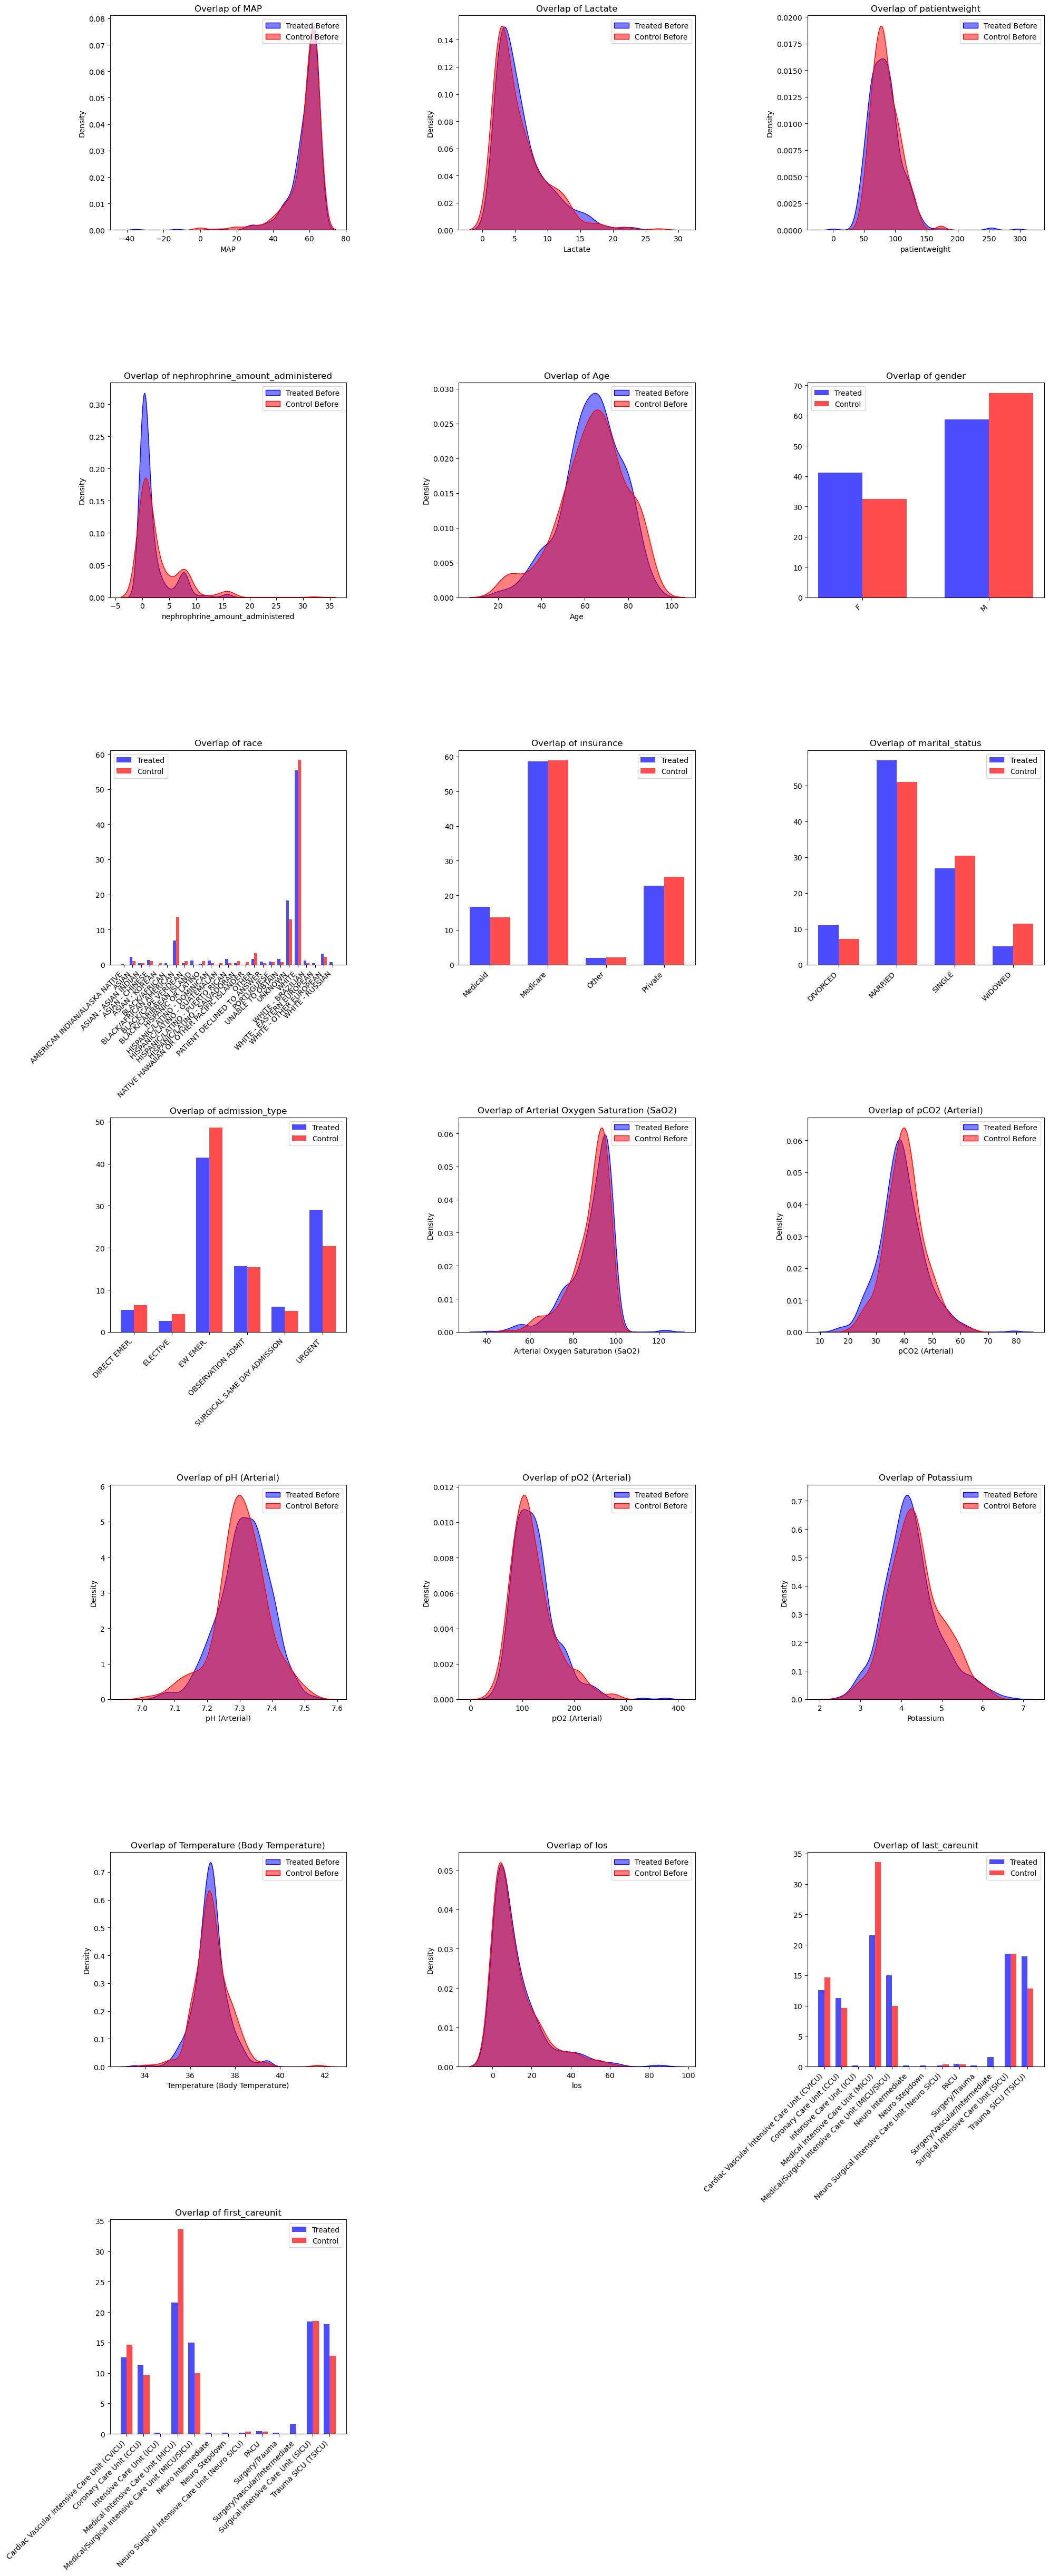

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Define treated_before and control_before groups
treated_before = cleaned_cohort[cleaned_cohort['is_nephrohrine_given_within_1_hours'] == 1]
control_before = cleaned_cohort[cleaned_cohort['is_nephrohrine_given_within_1_hours'] == 0]
# Define the list of covariates (numeric and categorical combined)
covariates = ['MAP', 'Lactate', 'patientweight',
       'nephrophrine_amount_administered', 'Age', 'gender', 'race',
       'insurance', 'marital_status', 'admission_type',
       'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)', 'los', 'last_careunit',
       'first_careunit']
# Colors for the plot
TREATED_COLOR = 'blue'
CONTROL_COLOR = 'red'
# Create subplots dynamically based on covariates
n_cols = 3
n_rows = (len(covariates) + n_cols - 1) // n_cols  # Calculate rows dynamically
plt.figure(figsize=(20, 7 * n_rows))
for i, cov in enumerate(covariates, 1):
    plt.subplot(n_rows, n_cols, i)
    # Check if the covariate is numeric
    if cleaned_cohort[cov].dtype in ['float64', 'int64']:
        # KDE plots for numeric covariates
        sns.kdeplot(data=treated_before, x=cov, label='Treated Before', fill=True, color=TREATED_COLOR, alpha=0.5)
        sns.kdeplot(data=control_before, x=cov, label='Control Before', fill=True, color=CONTROL_COLOR, alpha=0.5)
    else:
        # Bar plots for categorical covariates
        treated_counts = treated_before[cov].value_counts(normalize=True).sort_index()
        control_counts = control_before[cov].value_counts(normalize=True).sort_index()
        categories = sorted(set(treated_counts.index).union(control_counts.index))
        # Prepare data for the bar plot
        combined_data = pd.DataFrame({
            'Category': categories,
            'Treated': treated_counts.reindex(categories, fill_value=0) * 100,
            'Control': control_counts.reindex(categories, fill_value=0) * 100
        })
        # Plot stacked bar plots
        bar_width = 0.35
        x = np.arange(len(categories))
        plt.bar(x - bar_width/2, combined_data['Treated'], width=bar_width, label='Treated', color=TREATED_COLOR, alpha=0.7)
        plt.bar(x + bar_width/2, combined_data['Control'], width=bar_width, label='Control', color=CONTROL_COLOR, alpha=0.7)
        # Add category labels to x-axis
        plt.xticks(ticks=x, labels=categories, rotation=45, ha='right')
    plt.title(f'Overlap of {cov}')
    plt.legend()
# Adjust layout and display
plt.tight_layout()
plt.savefig('covariate_plot.jpeg')
plt.show()

In [249]:
 cleaned_cohort.isnull().sum()

subject_id                             0
hadm_id                                0
MAP                                    0
Lactate                                0
patientweight                          0
nephrophrine_amount_administered       0
Age                                    0
gender                                 0
race                                   0
insurance                              0
marital_status                         0
admission_type                         0
Arterial Oxygen Saturation (SaO2)      0
pCO2 (Arterial)                        0
pH (Arterial)                          0
pO2 (Arterial)                         0
Potassium                              0
Temperature (Body Temperature)         0
is_nephrohrine_given_within_1_hours    0
los                                    0
last_careunit                          0
first_careunit                         0
dod_within_28_days_of_septic_shock     0
dtype: int64

In [253]:
cleaned_cohort.to_csv("cleaned_cohort.csv", header = True)

RANDOM FOREST

In [352]:
# Define covariates, treatment, and outcome
covariates = ['MAP', 'Lactate', 'patientweight', 'Age', 'gender', 'race',
              'insurance', 'marital_status', 'admission_type', 'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)',
              'pH (Arterial)', 'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)','los', 'last_careunit',
       'first_careunit']
treatment = 'is_nephrohrine_given_within_1_hours'
outcome = 'dod_within_28_days_of_septic_shock'

In [355]:
# Drop identifiers and other irrelevant columns
exclude_columns = ['subject_id', 'hadm_id']  # Add other non-predictive columns if necessary
# Define covariates excluding identifiers and the outcome
covariates = [col for col in cleaned_cohort.columns if col not in exclude_columns + [treatment, outcome]]

In [357]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Assuming cleaned_cohort contains 'stay_id', 'hadm_id', and other columns
# Grouping by 'stay_id' and 'hadm_id' and aggregating
# You can use aggregation functions based on your data's needs, such as 'mean', 'sum', or 'first'
grouped_data = cleaned_cohort.groupby(['subject_id', 'hadm_id']).agg({
    'MAP': 'mean',
    'Lactate': 'mean',
    'patientweight': 'mean',
    'Age': 'mean',
    'Arterial Oxygen Saturation (SaO2)': 'mean',
    'pCO2 (Arterial)': 'mean',
    'pH (Arterial)': 'mean',
    'pO2 (Arterial)': 'mean',
    'Potassium': 'mean',
    'Temperature (Body Temperature)': 'mean',
    'is_nephrohrine_given_within_1_hours': 'mean',
    'dod_within_28_days_of_septic_shock': 'mean',
    'gender': 'first',  # You can take the first instance or most frequent
    'race': 'first',    # Similar to above
    'insurance': 'first',
    'marital_status': 'first',
    'admission_type': 'first',
    'last_careunit': 'first',
    'first_careunit': 'first'
}).reset_index()
# One-hot encode categorical variables
categorical_columns = ['gender', 'race', 'insurance', 'marital_status', 'admission_type', 'last_careunit', 'first_careunit']
data_encoded = pd.get_dummies(grouped_data, columns=categorical_columns, drop_first=True)
#data_encoded = grouped_data
# Define covariates and outcome
exclude_columns = ['subject_id', 'hadm_id', 'stay_id']  # Non-predictive identifiers
covariates = [col for col in data_encoded.columns if col not in exclude_columns + ['is_nephrohrine_given_within_1_hours', 'dod_within_28_days_of_septic_shock']]
X = data_encoded[covariates]
y = data_encoded['is_nephrohrine_given_within_1_hours']  # Adjust based on your model's outcome variable
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)
# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
# Create RandomForestClassifier
rf = RandomForestClassifier(random_state=36)
# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# Fit the model
grid_search.fit(X_train, y_train)
# Best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)
# Best Random Forest model
best_rf = grid_search.best_estimator_
# Re-fit the best model on the entire training data
best_rf.fit(X_train, y_train)
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
})
# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Display top features
print("Top Features by Importance:")
print(feature_importances.head(20))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Top Features by Importance:
                                             Feature  Importance
9                     Temperature (Body Temperature)    0.098988
2                                      patientweight    0.091275
7                                     pO2 (Arterial)    0.088261
8                                          Potassium    0.087616
5                                    pCO2 (Arterial)    0.082281
6                                      pH (Arterial)    0.079033
0                                                MAP    0.078200
4                  Arterial Oxygen Saturation (SaO2)    0.071906
1                                            Lactate    0.067854
3                                                Age    0.059636
40                            marital_status_WIDOWED    0.018805
10 

In [361]:
# Select features with importance greater than or equal to 0.015
threshold = 0.010
top_covariates = feature_importances[feature_importances['Importance'] >= threshold]['Feature'].tolist()
print("Top Covariates with Importance >= 0.010:")
print(top_covariates)

Top Covariates with Importance >= 0.010:
['Temperature (Body Temperature)', 'patientweight', 'pO2 (Arterial)', 'Potassium', 'pCO2 (Arterial)', 'pH (Arterial)', 'MAP', 'Arterial Oxygen Saturation (SaO2)', 'Lactate', 'Age', 'marital_status_WIDOWED', 'gender_M', 'admission_type_URGENT', 'race_WHITE']


PROPENSITY SCORE MATCHING

In [366]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Assuming cohort_with_vitals_cleaned is the cleaned dataframe with necessary columns
treatment = 'is_nephrohrine_given_within_1_hours'
outcome = 'dod_within_28_days_of_septic_shock'

In [368]:
# Prepare the data for matching
X_log = X[top_covariates]  # Covariates for logistic regression
y_log = data_encoded[treatment]   # Treatment indicator

In [370]:
X_log.isna().sum()

Temperature (Body Temperature)       0
patientweight                        0
pO2 (Arterial)                       0
Potassium                            0
pCO2 (Arterial)                      0
pH (Arterial)                        0
MAP                                  0
Arterial Oxygen Saturation (SaO2)    0
Lactate                              0
Age                                  0
marital_status_WIDOWED               0
gender_M                             0
admission_type_URGENT                0
race_WHITE                           0
dtype: int64

In [374]:
# Encode categorical variables using OneHotEncoder (keeping both categories)
#categorical_columns = ['gender', 'race', 'insurance', 'marital_status', 'admission_type']
#X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=False)

In [376]:
# pip install causalinference

In [378]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel
t = y_log
X = pd.get_dummies(data_encoded.drop(columns=[outcome, treatment]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
data_encoded['proba'] = pipe.predict_proba(X)[:,1]
data_encoded['logit'] = data_encoded['proba'].apply(lambda p: np.log(p/(1-p)))
data_encoded['pred'] = np.where(data_encoded['proba']>=threshold, 1, 0)
data_encoded.head()

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred
0,10036086,28728587,59.666667,4.7,113.2,57.0,82.513333,55.250000,7.229167,99.916667,...,False,False,False,False,False,False,False,0.261369,-1.038867,0
1,10055344,29209451,63.666667,7.6,77.0,83.0,55.000000,36.500000,7.174286,182.250000,...,False,False,False,False,False,False,False,0.328250,-0.716109,0
2,10087623,28570546,54.666667,10.8,73.0,48.0,98.000000,43.131579,7.251579,104.394737,...,False,False,False,False,False,False,False,0.564838,0.260819,1
3,10151556,20815067,53.000000,9.0,95.0,71.0,88.333333,42.384615,7.332857,127.384615,...,False,False,False,False,False,False,False,0.847151,1.712429,1
4,10192651,24449860,62.666667,13.9,71.6,29.0,83.333333,32.300000,7.079000,103.100000,...,False,False,False,False,False,False,False,0.761857,1.162887,1


In [380]:
import numpy as np
print(f"Accuracy: {np.mean(data_encoded[treatment]==data_encoded['pred']):.4f},\
 ROC AUC: {roc_auc_score(data_encoded[treatment], data_encoded['proba']):.4f},\
 F1-score: {f1_score(data_encoded[treatment], data_encoded['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(data_encoded[treatment], data_encoded['pred']).rename(columns={0: False,
                                                       1:True})

Accuracy: 0.6788, ROC AUC: 0.7074, F1-score: 0.7684


pred,False,True
is_nephrohrine_given_within_1_hours,,
0.0,80,126
1.0,50,292


## Inspection of the distribution of the propensity score and its logit transformation by the treatment groups

/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3472263246.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_encoded[control_mask], x='proba', shade=True,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3472263246.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_encoded[treatment_mask], x='proba', shade=True,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3472263246.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_encoded[control_mask], x='logit', shade=True,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/347226

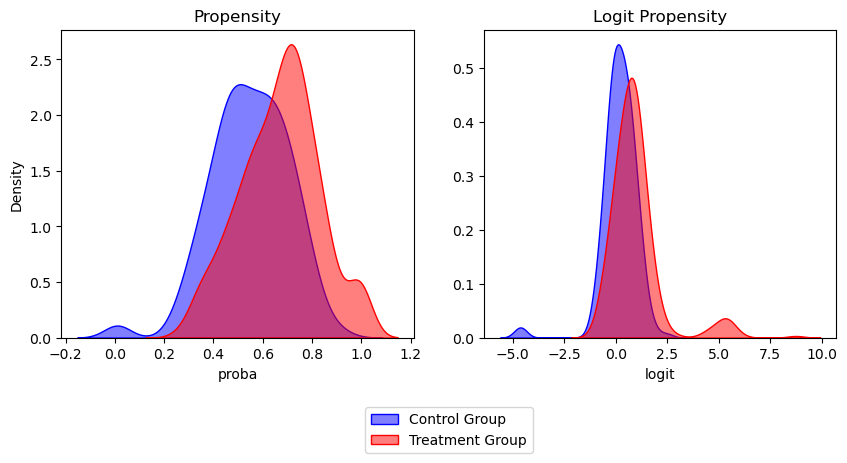

In [383]:
# Define colors and labels
C_COLOUR = 'blue'  # Color for control group
T_COLOUR = 'red'   # Color for treatment group
C_LABEL = 'Control Group'  # Label for control group
T_LABEL = 'Treatment Group'  # Label for treatment group
control_mask = data_encoded[treatment] == 0
treatment_mask = data_encoded[treatment] == 1
# Then use these in your plot
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=data_encoded[control_mask], x='proba', shade=True,
            color=C_COLOUR, label=C_LABEL, ax=ax[0],alpha =0.5)
sns.kdeplot(data=data_encoded[treatment_mask], x='proba', shade=True,
            color=T_COLOUR, label=T_LABEL, ax=ax[0],alpha =0.5)
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=data_encoded[control_mask], x='logit', shade=True,
            color=C_COLOUR, label=C_LABEL, ax=ax[1],alpha =0.5)
sns.kdeplot(data=data_encoded[treatment_mask], x='logit', shade=True,
            color=T_COLOUR, label=T_LABEL, ax=ax[1],alpha =0.5)
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

In [385]:
treatment

'is_nephrohrine_given_within_1_hours'

/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3004454997.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_group['Group'] = 'Treated'
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3004454997.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group['Group'] = 'Control'
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3004454997.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

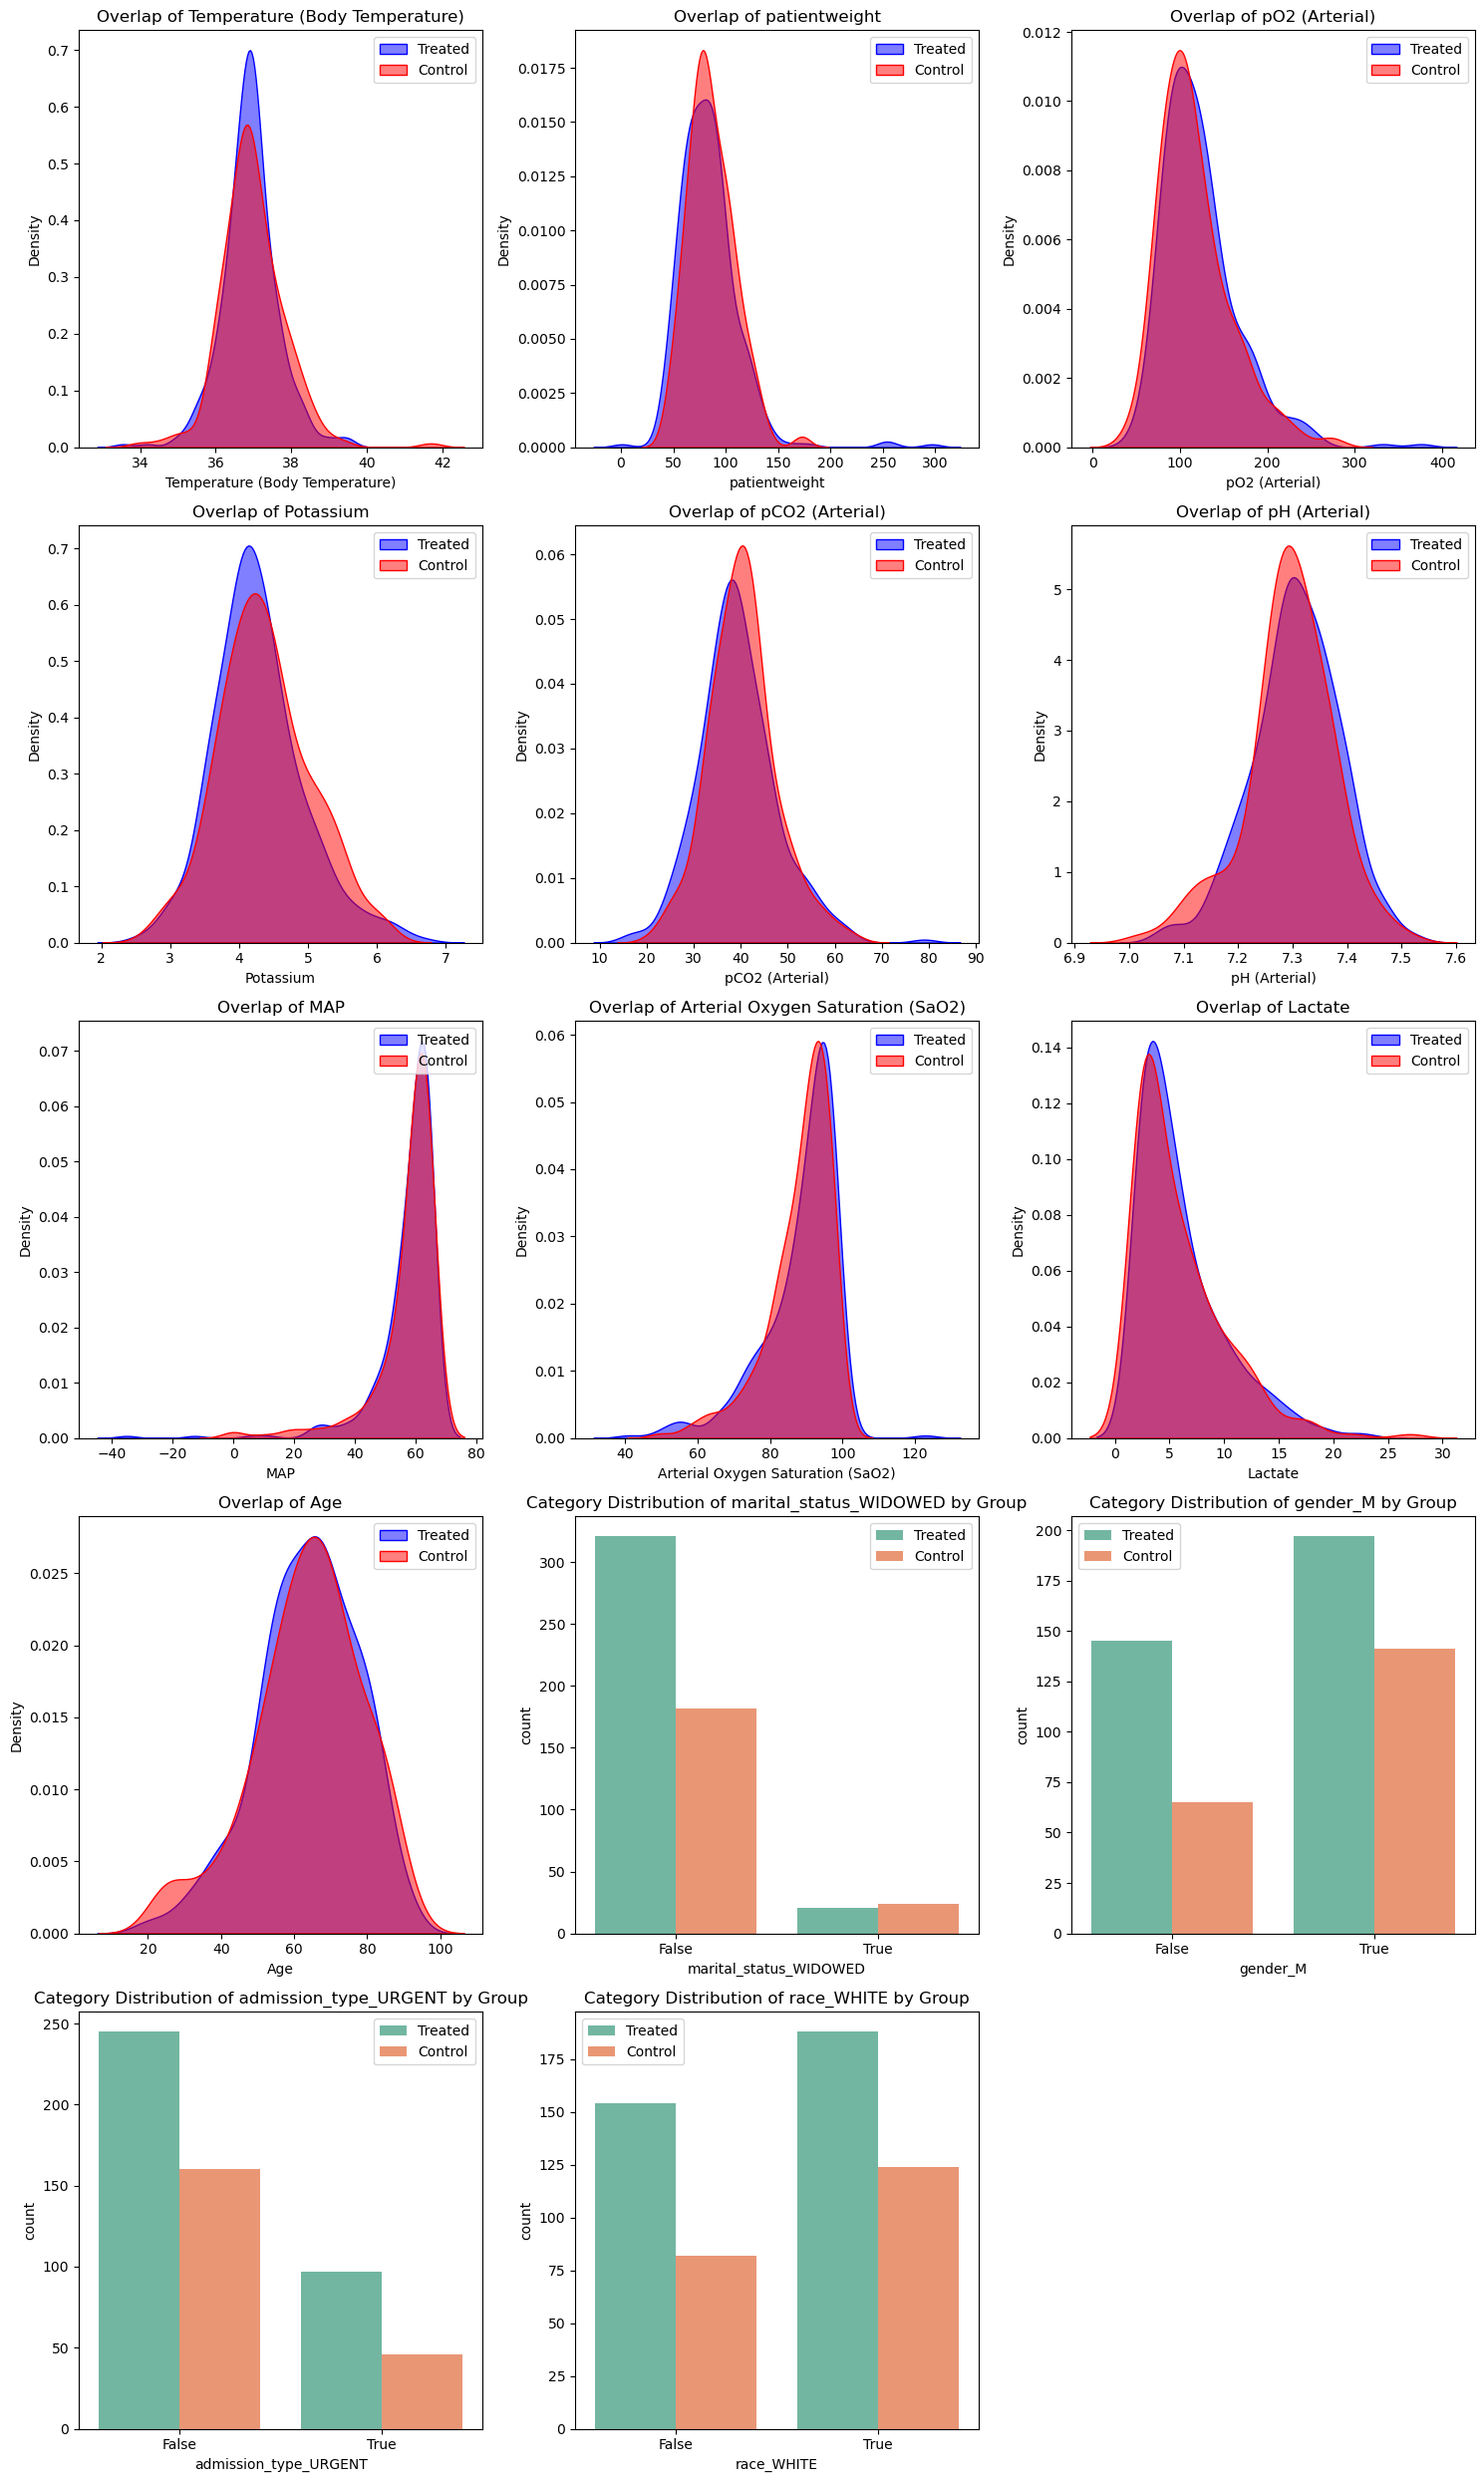

In [387]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define the list of covariates for which you want to check overlap
covariates = top_covariates
# Split the data into treatment and control groups
control_group = data_encoded[data_encoded[treatment] == 0]
treatment_group = data_encoded[data_encoded[treatment] == 1]
# Create subplots for the covariates (adjust the number of rows/columns based on the number of covariates)
n_cols = 3  # Adjust this to fit the number of covariates you're plotting
n_rows = (len(covariates) // n_cols) + 1
plt.figure(figsize=(15, 5 * n_rows))
for i, cov in enumerate(covariates, 1):
    plt.subplot(n_rows, n_cols, i)
    # Check if the covariate is numeric
    if treatment_group[cov].dtype in ['float64', 'int64']:  # Numeric variables
        sns.kdeplot(data=treatment_group, x=cov, label='Treated', fill=True, color='blue', alpha=0.5)
        sns.kdeplot(data=control_group, x=cov, label='Control', fill=True, color='red', alpha=0.5)
        plt.title(f'Overlap of {cov}')
    else:  # Categorical variables
        # Combine treatment and control groups into one dataframe for plotting
        treatment_group['Group'] = 'Treated'
        control_group['Group'] = 'Control'
        combined_df = pd.concat([treatment_group, control_group])
        # Create a countplot for the current categorical variable
        sns.countplot(data=combined_df, x=cov, hue='Group', palette="Set2")
        plt.title(f'Category Distribution of {cov} by Group')
    plt.legend()
plt.tight_layout()
plt.savefig('feature_selection_propensity_score.jpeg')
plt.show()

In [388]:
control_group

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred,Group
0,10036086,28728587,59.666667,4.7,113.2,57.0,82.513333,55.250000,7.229167,99.916667,...,False,False,False,False,False,False,0.261369,-1.038867,0,Control
4,10192651,24449860,62.666667,13.9,71.6,29.0,83.333333,32.300000,7.079000,103.100000,...,False,False,False,False,False,False,0.761857,1.162887,1,Control
6,10236942,21834040,64.666667,12.3,92.4,64.0,95.200000,25.272727,7.125455,107.818182,...,False,False,False,False,False,False,0.653943,0.636417,1,Control
7,10247357,24391454,61.333333,7.0,52.0,67.0,87.326667,51.250000,7.216250,87.000000,...,False,False,False,False,False,False,0.626978,0.519274,1,Control
8,10247549,28809590,0.000000,2.0,90.0,75.0,81.500000,48.750000,7.262500,101.500000,...,False,False,False,False,False,False,0.360670,-0.572457,0,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,19734681,25983525,58.333333,3.5,91.7,60.0,91.076923,40.172414,7.302069,127.172414,...,False,False,False,False,True,False,0.376254,-0.505480,0,Control
536,19889144,23805161,63.666667,3.0,76.0,68.0,91.666667,60.555556,7.234444,168.111111,...,False,False,False,False,False,False,0.531625,0.126667,1,Control
540,19933770,27972684,60.666667,3.0,65.0,59.0,91.428571,37.000000,7.310000,126.857143,...,False,False,False,False,False,False,0.445337,-0.219528,0,Control
542,19958216,27195494,60.333333,4.5,43.0,67.0,95.000000,40.000000,7.329167,104.916667,...,False,False,False,False,False,False,0.499300,-0.002800,0,Control


In [391]:
treatment_group

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred,Group
1,10055344,29209451,63.666667,7.6,77.0,83.0,55.000000,36.500000,7.174286,182.250000,...,False,False,False,False,False,False,0.328250,-0.716109,0,Treated
2,10087623,28570546,54.666667,10.8,73.0,48.0,98.000000,43.131579,7.251579,104.394737,...,False,False,False,False,False,False,0.564838,0.260819,1,Treated
3,10151556,20815067,53.000000,9.0,95.0,71.0,88.333333,42.384615,7.332857,127.384615,...,False,False,False,False,False,False,0.847151,1.712429,1,Treated
5,10206125,20196752,64.666667,19.0,62.2,73.0,94.250000,37.909091,7.212727,123.636364,...,False,False,False,False,True,False,0.670466,0.710292,1,Treated
11,10285708,24782848,58.000000,2.0,45.0,81.0,91.105556,39.800000,7.206000,70.000000,...,False,False,False,False,False,False,0.638456,0.568667,1,Treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,19957675,21799993,60.333333,2.3,96.2,72.0,89.200000,31.800000,7.388000,138.200000,...,False,False,False,False,False,False,0.802927,1.404689,1,Treated
543,19965625,26179795,60.000000,3.6,91.0,82.0,80.000000,34.363636,7.281818,108.545455,...,False,False,False,False,False,True,0.691533,0.807296,1,Treated
544,19970470,23848017,63.333333,12.9,114.0,56.0,92.666667,53.000000,7.128571,91.857143,...,False,False,False,False,False,False,0.701225,0.853140,1,Treated
545,19971771,26230047,61.666667,2.2,90.0,83.0,98.000000,40.428571,7.291429,87.000000,...,False,False,False,False,True,False,0.579481,0.320644,1,Treated


## Step 3: Match Records 
We are going to match the most similar control records to the patients in the treatment group. Finding similar records in one dimension (propensity score) is much easier than doing so in many dimensions (confounders). This means, if we match records based on the propensity score, the distribution of the confounders between matched records will likely be similar.

In the following script, we find a control record with the most similar propensity score for each example in the treatment group (one-to-one matching). When doing so, we will sample the control records with replacement. This means some control records can be matched multiple times to different treatment records, whereas some control records are not matched at all.

In [393]:
data_encoded

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred
0,10036086,28728587,59.666667,4.7,113.2,57.0,82.513333,55.250000,7.229167,99.916667,...,False,False,False,False,False,False,False,0.261369,-1.038867,0
1,10055344,29209451,63.666667,7.6,77.0,83.0,55.000000,36.500000,7.174286,182.250000,...,False,False,False,False,False,False,False,0.328250,-0.716109,0
2,10087623,28570546,54.666667,10.8,73.0,48.0,98.000000,43.131579,7.251579,104.394737,...,False,False,False,False,False,False,False,0.564838,0.260819,1
3,10151556,20815067,53.000000,9.0,95.0,71.0,88.333333,42.384615,7.332857,127.384615,...,False,False,False,False,False,False,False,0.847151,1.712429,1
4,10192651,24449860,62.666667,13.9,71.6,29.0,83.333333,32.300000,7.079000,103.100000,...,False,False,False,False,False,False,False,0.761857,1.162887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19965625,26179795,60.000000,3.6,91.0,82.0,80.000000,34.363636,7.281818,108.545455,...,False,False,False,False,False,False,True,0.691533,0.807296,1
544,19970470,23848017,63.333333,12.9,114.0,56.0,92.666667,53.000000,7.128571,91.857143,...,False,False,False,False,False,False,False,0.701225,0.853140,1
545,19971771,26230047,61.666667,2.2,90.0,83.0,98.000000,40.428571,7.291429,87.000000,...,False,False,False,False,False,True,False,0.579481,0.320644,1
546,19983257,21588174,60.666667,3.4,118.6,64.0,92.868000,46.000000,7.343333,107.333333,...,False,False,False,False,False,False,False,0.534623,0.138714,1


In [395]:
data_encoded['proba'].isna().sum()

0

In [397]:
# Check the distribution of predicted values (0 and 1) in the 'pred' column
data_encoded[treatment].value_counts()

is_nephrohrine_given_within_1_hours
1.0    342
0.0    206
Name: count, dtype: int64

In [399]:
# import matplotlib.pyplot as plt
# # Plot the distribution of predicted values
# plt.figure(figsize=(6, 4))
# plt.bar(['Class 0', 'Class 1'], [y_pred.tolist().count(0), y_pred.tolist().count(1)], color=['skyblue', 'salmon'])
# plt.title('Distribution of Predicted Classes')
# plt.ylabel('Count')
# plt.show()

## MATCHING

In [403]:
# Convert treatment column to boolean (True for 1.0, False for 0.0)
data_encoded[treatment] = data_encoded[treatment].astype(bool)
print(treatment)
# Now `treatment` will be True for 1.0 and False for 0.0
data_encoded[treatment]

is_nephrohrine_given_within_1_hours


0      False
1       True
2       True
3       True
4      False
       ...  
543     True
544     True
545     True
546     True
547    False
Name: is_nephrohrine_given_within_1_hours, Length: 548, dtype: bool

## Matching method 1

In [406]:
# Sort by 'logit' so it's quicker to find match
data_encoded.sort_values('logit', inplace=True)
n = len(data_encoded) - 1
for i, (ind, row) in enumerate(data_encoded.iterrows()):
    if row[treatment]:  # Check if the record is treated (treatment == 1)
        # Match the closest untreated record (control) among records sorted higher
        if i < n:
            above = data_encoded.iloc[i:]
            control_above = above[~above[treatment]]  # Untreated (control) group
            if not control_above.empty:  # Check if there are control units available
                match_above = control_above.iloc[0]  # Get the closest match
                distance_above = match_above['logit'] - row['logit']
                data_encoded.loc[ind, 'match'] = match_above.name
                data_encoded.loc[ind, 'distance'] = distance_above
        # Match the closest untreated record (control) among records sorted lower
        if i > 0:
            below = data_encoded.iloc[:i]
            control_below = below[~below[treatment]]  # Untreated (control) group
            if not control_below.empty:  # Check if there are control units available
                match_below = control_below.iloc[-1]  # Get the closest match
                distance_below = match_below['logit'] - row['logit']
                if distance_below < distance_above:  # Only overwrite if the below match is closer
                    data_encoded.loc[ind, 'match'] = match_below.name
                    data_encoded.loc[ind, 'distance'] = distance_below

In [408]:
data_encoded

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred,match,distance
462,18639330,26211758,61.333333,5.6,89.1,58.0,90.250000,46.470588,7.255000,78.264706,...,False,False,False,False,False,0.008773,-4.727229,0,NaN,NaN
385,17217207,26553947,54.666667,7.3,50.0,72.0,94.000000,42.307692,7.326538,77.000000,...,False,False,False,False,False,0.009568,-4.639669,0,NaN,NaN
515,19530582,26654052,57.666667,5.1,94.0,76.0,95.214286,39.409091,7.333636,136.318182,...,False,False,False,False,True,0.010878,-4.510120,0,NaN,NaN
13,10308247,29744573,25.666667,6.0,125.0,54.0,88.500000,34.818182,7.168182,130.000000,...,False,False,False,False,False,0.242987,-1.136373,0,NaN,NaN
57,11013572,24572136,64.666667,4.8,69.3,68.0,83.939746,46.785714,7.330000,77.642857,...,False,False,False,True,False,0.252989,-1.082731,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,15407956,28000201,63.000000,6.3,95.0,59.0,97.000000,43.875000,7.168750,171.250000,...,True,False,False,False,False,0.995897,5.491872,1,293.0,-3.003431
299,15575136,22706972,59.333333,3.1,126.0,44.0,87.666667,34.773585,7.350370,124.773585,...,False,False,False,False,False,0.996232,5.577538,1,293.0,-3.089097
248,14786296,27321056,63.000000,4.2,73.5,33.0,94.263158,38.761905,7.329048,178.142857,...,False,False,False,False,False,0.996757,5.728041,1,293.0,-3.239599
423,18010283,23557292,64.000000,3.3,84.9,53.0,95.400000,56.375000,7.356250,114.500000,...,False,False,True,False,False,0.997484,5.982667,1,293.0,-3.494226


Matching is done. We will now create a new data set called matched_df that contains the original treatment group and a new control group:

In [411]:
indices = data_encoded[data_encoded['match'].notna()].index.append(
    pd.Index(data_encoded.loc[data_encoded['match'].notna(), 'match'])
)
matched_df = data_encoded.loc[indices].reset_index(drop=True)
matched_df

,subject_id,hadm_id,MAP,Lactate,patientweight,Age,Arterial Oxygen Saturation (SaO2),pCO2 (Arterial),pH (Arterial),pO2 (Arterial),...,first_careunit_PACU,first_careunit_Surgery/Trauma,first_careunit_Surgery/Vascular/Intermediate,first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),proba,logit,pred,match,distance
0,19519120,28820532,62.333333,9.8,97.6,61.0,96.333333,34.000000,7.342222,107.222222,...,False,False,False,False,False,0.273051,-0.979197,0,330.0,-0.004760
1,14239401,21199923,53.666667,2.2,90.0,66.0,88.750000,46.200000,7.264000,68.200000,...,False,False,False,False,False,0.299315,-0.850560,0,278.0,-0.010104
2,18341278,29741370,64.000000,3.3,112.5,56.0,97.000000,32.000000,7.470000,99.000000,...,False,False,False,False,False,0.316048,-0.771995,0,348.0,-0.012982
3,10055344,29209451,63.666667,7.6,77.0,83.0,55.000000,36.500000,7.174286,182.250000,...,False,False,False,False,False,0.328250,-0.716109,0,205.0,-0.001960
4,13473495,23354564,64.666667,9.0,164.0,53.0,96.897436,29.000000,7.300000,162.600000,...,False,False,False,False,False,0.333847,-0.690834,0,205.0,-0.027235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,15521319,21153495,61.000000,12.9,119.0,86.0,93.600000,39.672414,7.346333,136.931034,...,False,False,False,False,True,0.923328,2.488441,1,NaN,NaN
680,15521319,21153495,61.000000,12.9,119.0,86.0,93.600000,39.672414,7.346333,136.931034,...,False,False,False,False,True,0.923328,2.488441,1,NaN,NaN
681,15521319,21153495,61.000000,12.9,119.0,86.0,93.600000,39.672414,7.346333,136.931034,...,False,False,False,False,True,0.923328,2.488441,1,NaN,NaN
682,15521319,21153495,61.000000,12.9,119.0,86.0,93.600000,39.672414,7.346333,136.931034,...,False,False,False,False,True,0.923328,2.488441,1,NaN,NaN


In [413]:
# Check the distribution of predicted values (0 and 1) in the 'pred' column
matched_df[treatment].value_counts()

is_nephrohrine_given_within_1_hours
True     342
False    342
Name: count, dtype: int64

In [415]:
matched_df.columns

Index(['subject_id', 'hadm_id', 'MAP', 'Lactate', 'patientweight', 'Age',
       'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)',
       'is_nephrohrine_given_within_1_hours',
       'dod_within_28_days_of_septic_shock', 'gender_M', 'race_ASIAN',
       'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_BLACK/AFRICAN',
       'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN',
       'race_BLACK/CARIBBEAN ISLAND', 'race_HISPANIC OR LATINO',
       'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN',
       'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_UNABLE TO OBTAIN', 'race_UNKNOWN', 'race_WHITE',
       'race_WHITE - BRAZILIAN', 'race_WHITE - EAST

This new control group should be more similar to the treatment group according to the confounding factors. Let’s find out if that’s the case in the next section.

## Step 4: Evaluate the Quality of the Matched Records 
It’s time to evaluate how good the matching was. Let’s inspect if the groups look more comparable in terms of the confounders:

In [425]:
for var in ['logit', 'Temperature (Body Temperature)', 'patientweight',
            'pO2 (Arterial)', 'Potassium', 'pCO2 (Arterial)',
            'pH (Arterial)', 'MAP', 'Arterial Oxygen Saturation (SaO2)',
            'Lactate', 'Age', 'marital_status_WIDOWED', 'gender_M']:
    # Print the variable name and group summary before matching
    print(f"{var} | Before matching")
    display(data_encoded.groupby(treatment)[var].describe())
    # Print the variable name and group summary after matching
    print(f"{var} | After matching")
    display(matched_df.groupby(treatment)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,0.178187,0.856979,-4.727229,-0.205498,0.206008,0.670978,2.488441
True,342.0,0.947113,1.276974,-0.979197,0.246325,0.779341,1.201139,8.735982


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,0.762378,0.754198,-0.983957,0.234950,0.765187,1.197259,2.488441
True,342.0,0.947113,1.276974,-0.979197,0.246325,0.779341,1.201139,8.735982


Temperature (Body Temperature) | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,36.973652,0.850976,33.957143,36.518056,36.900000,37.385000,41.7
True,342.0,36.904339,0.734591,33.550000,36.530639,36.903167,37.224936,39.5


Temperature (Body Temperature) | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,37.001779,0.859809,33.957143,36.504167,36.900000,37.550000,39.4
True,342.0,36.904339,0.734591,33.550000,36.530639,36.903167,37.224936,39.5


patientweight | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,86.194175,22.343582,43.0,70.15,82.3,100.0,175.0
True,342.0,83.592690,29.035080,1.0,64.50,80.0,95.0,296.8


patientweight | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,88.353801,25.35296,45.0,70.6,87.15,107.3,175.0
True,342.0,83.592690,29.03508,1.0,64.5,80.00,95.0,296.8


pO2 (Arterial) | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,116.678188,40.993848,39.357143,87.019231,106.57619,136.266414,277.285714
True,342.0,122.917484,43.506604,43.000000,92.513889,115.45000,140.645833,375.705882


pO2 (Arterial) | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,123.055303,37.265146,51.6,97.497976,114.512195,145.651515,268.076923
True,342.0,122.917484,43.506604,43.0,92.513889,115.450000,140.645833,375.705882


Potassium | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,4.373041,0.667481,2.70,3.930833,4.314815,4.783333,6.10
True,342.0,4.277535,0.653258,2.55,3.865196,4.179808,4.600000,6.66


Potassium | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,4.307857,0.616905,2.70,3.939286,4.200000,4.66875,5.516667
True,342.0,4.277535,0.653258,2.55,3.865196,4.179808,4.60000,6.660000


pCO2 (Arterial) | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,40.324425,7.186275,21.111111,35.552083,40.000000,43.720395,64.111111
True,342.0,39.346165,8.236149,16.375000,34.355615,38.666667,43.637080,79.027027


pCO2 (Arterial) | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,39.304737,7.152834,21.111111,34.888889,39.672414,43.789474,64.111111
True,342.0,39.346165,8.236149,16.375000,34.355615,38.666667,43.637080,79.027027


pH (Arterial) | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,7.293659,0.082044,7.012222,7.258497,7.297212,7.343333,7.516667
True,342.0,7.305805,0.079603,7.056471,7.259375,7.305518,7.359398,7.520000


pH (Arterial) | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,7.297211,0.087603,7.083846,7.260952,7.298000,7.346333,7.516667
True,342.0,7.305805,0.079603,7.056471,7.259375,7.305518,7.359398,7.520000


MAP | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,57.043689,10.827734,0.0,56.000000,61.000000,63.0,64.666667
True,342.0,57.357445,10.442615,-35.0,55.083333,60.666667,63.0,64.666667


MAP | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,57.546784,10.337397,0.0,56.000000,61.000000,63.333333,64.666667
True,342.0,57.357445,10.442615,-35.0,55.083333,60.666667,63.000000,64.666667


Arterial Oxygen Saturation (SaO2) | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,88.142744,8.873691,49.8,83.958333,90.961538,94.4750,99.000000
True,342.0,88.416338,10.294071,41.0,84.360417,91.681250,95.5825,122.866667


Arterial Oxygen Saturation (SaO2) | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,89.362414,8.827735,49.8,86.000000,92.153846,95.2000,99.000000
True,342.0,88.416338,10.294071,41.0,84.360417,91.681250,95.5825,122.866667


Lactate | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,5.873301,4.149548,2.0,2.725,4.5,7.85,27.0
True,342.0,6.052924,3.948901,2.0,3.100,4.8,8.00,23.0


Lactate | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,6.673392,4.431210,2.0,3.1,5.2,10.2,27.0
True,342.0,6.052924,3.948901,2.0,3.1,4.8,8.0,23.0


Age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,206.0,63.466019,15.003294,22.0,55.0,65.0,73.0,91.0
True,342.0,63.798246,13.796497,19.0,55.0,65.0,74.0,91.0


Age | After matching


,count,mean,std,min,25%,50%,75%,max
is_nephrohrine_given_within_1_hours,,,,,,,,
False,342.0,65.178363,16.388083,23.0,55.0,67.0,76.0,91.0
True,342.0,63.798246,13.796497,19.0,55.0,65.0,74.0,91.0


marital_status_WIDOWED | Before matching


,count,unique,top,freq
is_nephrohrine_given_within_1_hours,,,,
False,206,2,False,182
True,342,2,False,321


marital_status_WIDOWED | After matching


,count,unique,top,freq
is_nephrohrine_given_within_1_hours,,,,
False,342,2,False,316
True,342,2,False,321


gender_M | Before matching


,count,unique,top,freq
is_nephrohrine_given_within_1_hours,,,,
False,206,2,True,141
True,342,2,True,197


gender_M | After matching


,count,unique,top,freq
is_nephrohrine_given_within_1_hours,,,,
False,342,2,True,200
True,342,2,True,197


Categorical Variable: marital_status_WIDOWED
Categorical Variable: gender_M
Numerical Variable: logit
Numerical Variable: Temperature (Body Temperature)
Numerical Variable: patientweight
Numerical Variable: pO2 (Arterial)
Numerical Variable: Potassium
Numerical Variable: pCO2 (Arterial)
Numerical Variable: pH (Arterial)
Numerical Variable: MAP
Numerical Variable: Arterial Oxygen Saturation (SaO2)
Numerical Variable: Lactate
Numerical Variable: Age
Categorical Variables Descriptive Statistics:


,count,unique,top,freq,Stage
is_nephrohrine_given_within_1_hours,,,,,
False,206,2,False,182,Before matching
True,342,2,False,321,Before matching
False,342,2,False,316,After matching
True,342,2,False,321,After matching
False,206,2,True,141,Before matching
True,342,2,True,197,Before matching
False,342,2,True,200,After matching
True,342,2,True,197,After matching


Numerical Variables Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max,Stage
is_nephrohrine_given_within_1_hours,,,,,,,,,
False,206.0,0.178187,0.856979,-4.727229,-0.205498,0.206008,0.670978,2.488441,Before matching
True,342.0,0.947113,1.276974,-0.979197,0.246325,0.779341,1.201139,8.735982,Before matching
False,342.0,0.762378,0.754198,-0.983957,0.234950,0.765187,1.197259,2.488441,After matching
True,342.0,0.947113,1.276974,-0.979197,0.246325,0.779341,1.201139,8.735982,After matching
False,206.0,36.973652,0.850976,33.957143,36.518056,36.900000,37.385000,41.700000,Before matching
True,342.0,36.904339,0.734591,33.550000,36.530639,36.903167,37.224936,39.500000,Before matching
False,342.0,37.001779,0.859809,33.957143,36.504167,36.900000,37.550000,39.400000,After matching
True,342.0,36.904339,0.734591,33.550000,36.530639,36.903167,37.224936,39.500000,After matching
False,206.0,86.194175,22.343582,43.000000,70.150000,82.300000,100.000000,175.000000,Before matching


In [319]:
summary_stats_before = data_encoded.groupby(treatment)[var].describe()

In [423]:
import pandas as pd
# Initialize an empty list to store results
results = []
# List of variables
variables = ['logit', 'Temperature (Body Temperature)', 'patientweight', 'pO2 (Arterial)',
             'Potassium', 'pCO2 (Arterial)', 'pH (Arterial)', 'MAP',
             'Arterial Oxygen Saturation (SaO2)', 'Lactate', 'Age',
             'marital_status_WIDOWED', 'gender_M']
# Loop through variables and compute descriptive statistics
for var in variables:
    # Before matching
    before_stats = data_encoded.groupby(treatment)[var].describe().reset_index()
    before_stats['Matching'] = 'Before'
    before_stats['Variable'] = var
    # After matching
    after_stats = matched_df.groupby(treatment)[var].describe().reset_index()
    after_stats['Matching'] = 'After'
    after_stats['Variable'] = var
    # Append both to the results
    results.append(before_stats)
    results.append(after_stats)
# Combine all results into a single DataFrame
final_df = pd.concat(results, ignore_index=True)
# Save as a LaTeX table
latex_code = final_df.to_latex(index=False, longtable=True)
# Save to a file
with open("descriptive_statistics.tex", "w") as f:
    f.write(latex_code)
print("LaTeX table saved as 'descriptive_statistics.tex'")

LaTeX table saved as 'descriptive_statistics.tex'


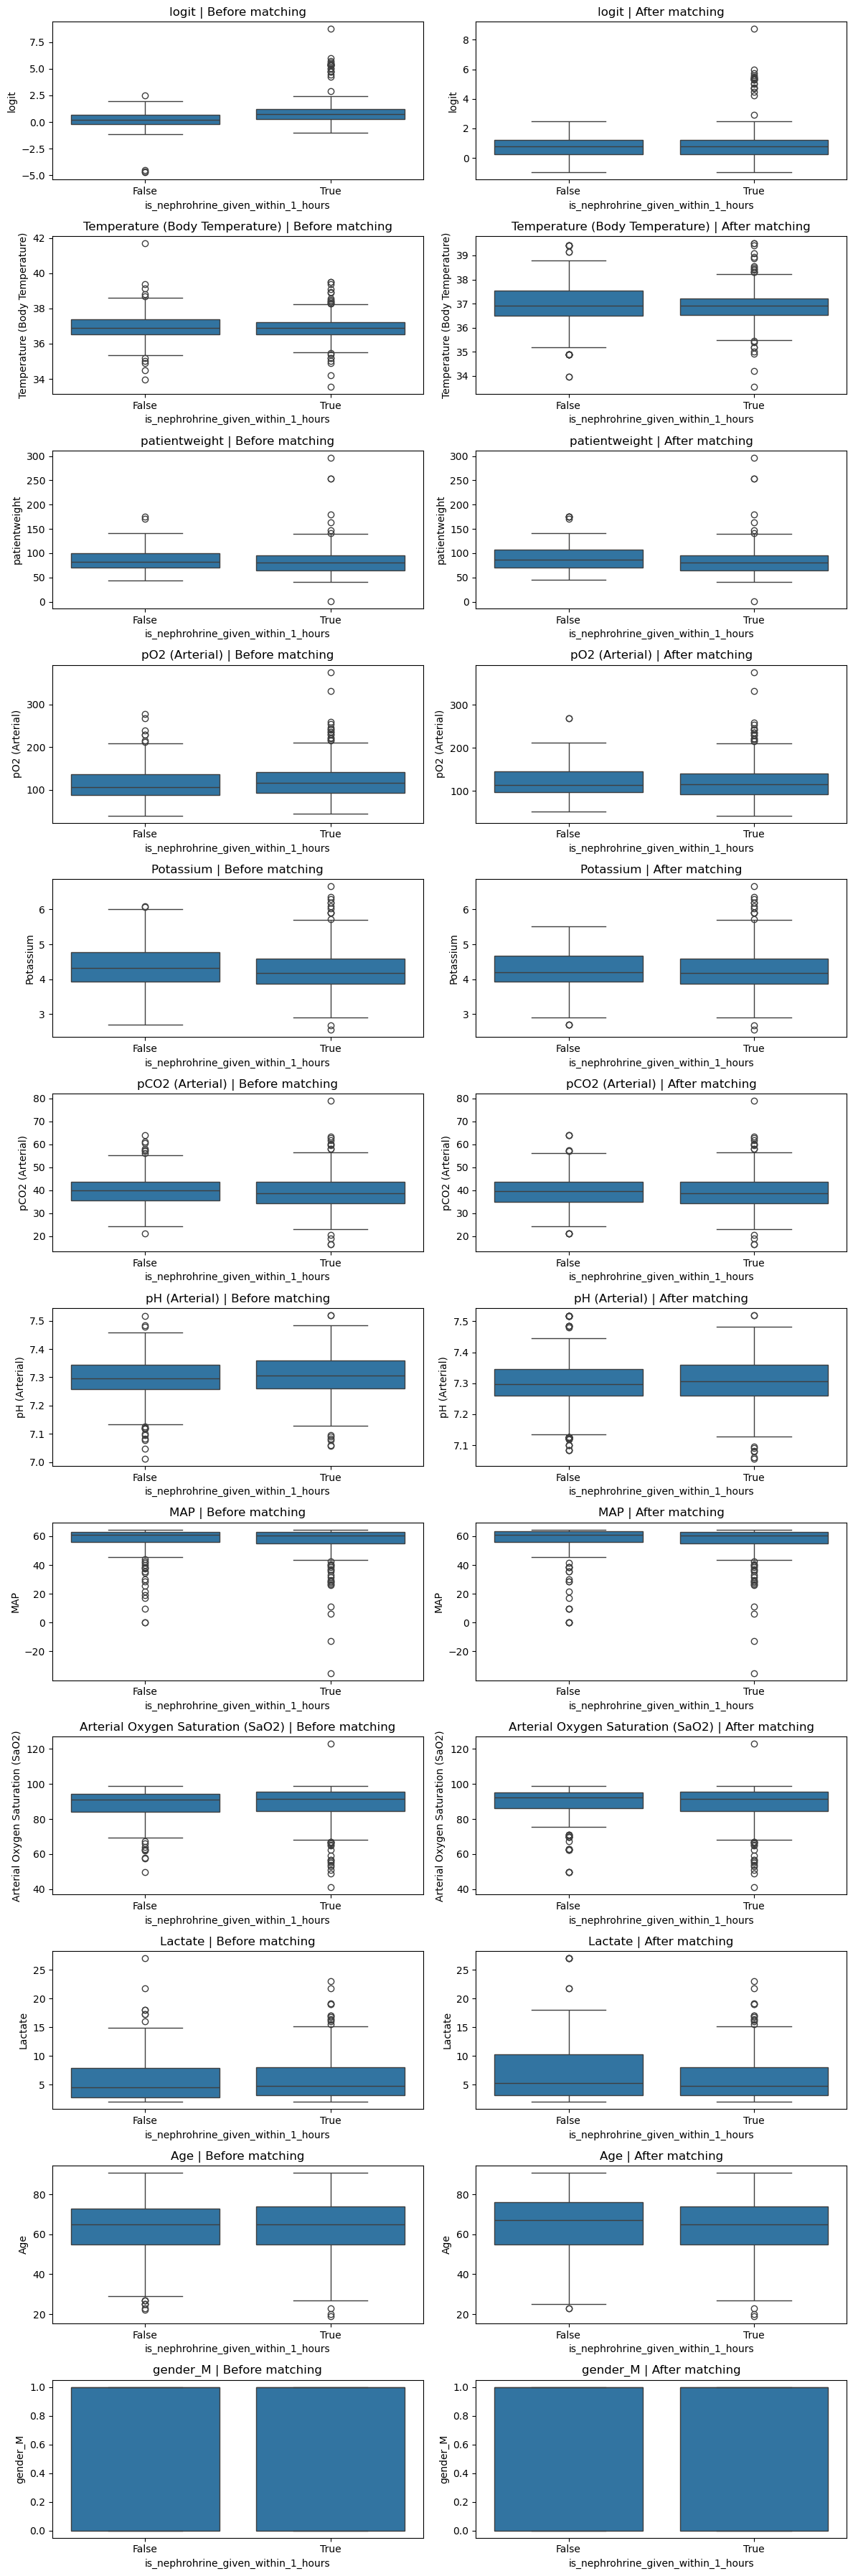

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming `matched_df` and `data_encoded` are your DataFrames and contain the necessary variables
variables = ['logit', 'Temperature (Body Temperature)', 'patientweight',
             'pO2 (Arterial)', 'Potassium', 'pCO2 (Arterial)',
             'pH (Arterial)', 'MAP', 'Arterial Oxygen Saturation (SaO2)',
             'Lactate', 'Age', 'gender_M']
# Create subplots with enough space for each variable comparison
fig, axes = plt.subplots(len(variables), 2, figsize=(12, 3 * len(variables)))
# Iterate over the variables and plot the distributions
for idx, var in enumerate(variables):
    # Plot Before Matching
    sns.boxplot(data=data_encoded, x='is_nephrohrine_given_within_1_hours', y=var, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{var} | Before matching')
    # Plot After Matching
    sns.boxplot(data=matched_df, x='is_nephrohrine_given_within_1_hours', y=var, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{var} | After matching')
# Adjust layout for better readability
plt.tight_layout()
plt.savefig("boxplot_before_after_matching.png")
plt.show()

In [331]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.table.plotting import table # EDIT: see deprecation warnings below
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, summary_stats_before)  # where df is your data frame
plt.savefig('mytable.png')

ModuleNotFoundError: No module named 'pandas.table'

In [335]:
import pandas as pd
# Assuming you have a DataFrame named 'summary_stats_before'
summary_stats_before.to_latex("summary_stats_before.tex", index=False, caption="Summary Statistics Before Treatment")

/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3246562899.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_encoded[~data_encoded[treatment]], x=var, shade=True,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3246562899.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_encoded[data_encoded[treatment]], x=var, shade=True,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/3246562899.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=matched_df[~matched_df[treatment]], x=var,
/var/folders/4h/7d14srh9427f80ydt2svl4cc0000gn/T/ipykernel_44396/324

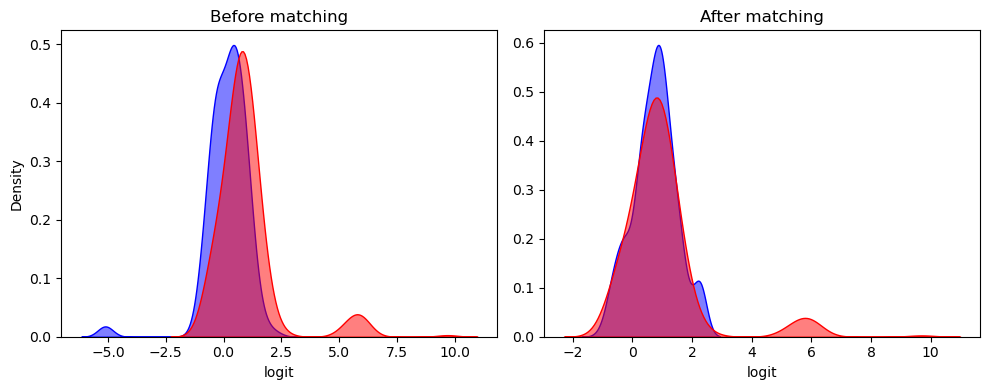

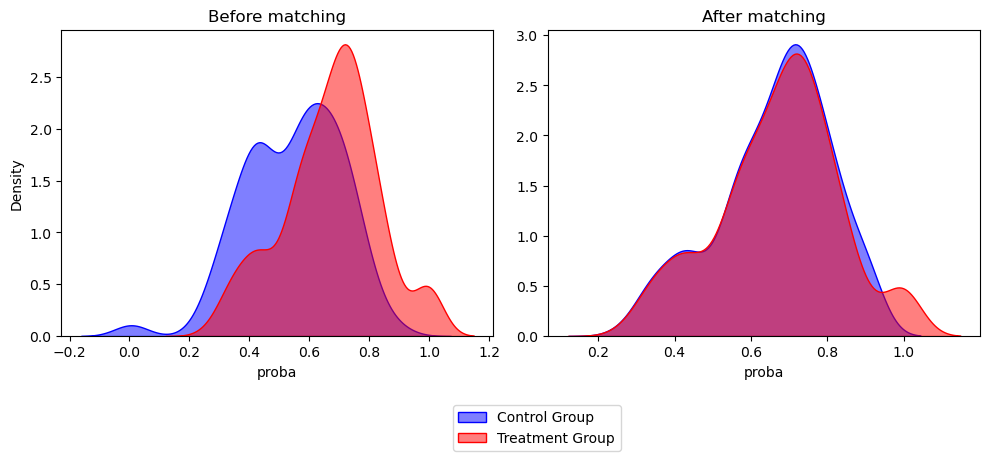

In [315]:
for var in ['logit','proba']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=data_encoded[~data_encoded[treatment]], x=var, shade=True,
                color=C_COLOUR, label=C_LABEL, ax=ax[0],alpha = 0.5)
    sns.kdeplot(data=data_encoded[data_encoded[treatment]], x=var, shade=True,
                color=T_COLOUR, label=T_LABEL, ax=ax[0],alpha = 0.5)
    ax[0].set_title('Before matching')
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[treatment]], x=var,
                shade=True, color=C_COLOUR, label=C_LABEL, ax=ax[1],alpha = 0.5)
    sns.kdeplot(data=matched_df[matched_df[treatment]], x=var,
                shade=True, color=T_COLOUR, label=T_LABEL, ax=ax[1],alpha = 0.5)
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [317]:
matched_df.to_csv("matched_df.csv", header = True)

## METHOD 1

In [ ]:
summary = matched_df.groupby(treatment)[outcome]\
                    .aggregate(['mean', 'std', 'count'])
summary

In [ ]:
c_outcome = summary.loc[False, 'mean']
t_outcome =  summary.loc[True, 'mean']
att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))
# y = data_encoded['dod_within_28_days_of_septic_shock'].values
# t = data_encoded['is_nephrohrine_given_within_1_hours'].values
# X = data_encoded[['Potassium', 'Temperature (Body Temperature)', 'patientweight', 'pO2 (Arterial)', 'pCO2 (Arterial)',
#                   'Lactate', 'Arterial Oxygen Saturation (SaO2)', 'pH (Arterial)', 'MAP', 'Age', 'gender_M',
#                   'admission_type_URGENT', 'marital_status_WIDOWED', 'insurance_Private', 'race_WHITE',
#                   'insurance_Medicare', 'admission_type_EW EMER.', 'first_careunit_Medical Intensive Care Unit (MICU)']]
# X = pd.DataFrame(StandardScaler().fit_transform(X),
#                  columns=X.columns).values
# model = CausalModel(y, t, X)
# model.est_via_matching()
# print(model.estimates)

## METHOD 2

In [ ]:
treated_group = matched_df[matched_df['is_nephrohrine_given_within_1_hours'] == 1]
control_group = matched_df[matched_df['is_nephrohrine_given_within_1_hours'] == 0]

In [ ]:
treated_group

In [ ]:
control_group

In [ ]:
# Compute weights based on propensity scores
treated_group['weight'] = 1 / treated_group['proba']
control_group['weight'] = 1 / (1 - control_group['proba'])
# Combine the groups with weights
weighted_data = pd.concat([treated_group, control_group], axis=0)
# Calculate the weighted average outcome for treated and control groups
weighted_treated_outcome = (treated_group[outcome] * treated_group['weight']).sum() / treated_group['weight'].sum()
weighted_control_outcome = (control_group[outcome] * control_group['weight']).sum() / control_group['weight'].sum()
print(f'Weighted Outcome for Treated: {weighted_treated_outcome}')
print(f'Weighted Outcome for Control: {weighted_control_outcome}')
# Estimate the Average Treatment Effect (ATE)
ATE = weighted_treated_outcome - weighted_control_outcome
print(f'Average Treatment Effect (ATE): {ATE}')

## METHOD 3

In [ ]:
y = matched_df[outcome].values
t = matched_df[treatment].values
X = matched_df[top_covariates]
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)

In [ ]:
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)

In [ ]:
causal.reset()

In [ ]:
y = matched_df[outcome].values
t = matched_df[treatment].values
X = matched_df[top_covariates]
# X = pd.DataFrame(StandardScaler().fit_transform(X),
#                  columns=X.columns).values
causal = CausalModel(y, t, X)
print(causal.summary_stats)

In [ ]:
causal.est_via_ols()

In [ ]:
print(causal.estimates)

In [ ]:
causal.est_propensity_s()

In [ ]:
X

In [ ]:
y

In [ ]:
t

## METHOD 4

In [ ]:
import pandas as pd
import dowhy.api
from dowhy import CausalModel

In [ ]:
matched_df.columns

In [ ]:
model = CausalModel(
    data=matched_df,
    treatment="is_nephrohrine_given_within_1_hours",
    outcome="dod_within_28_days_of_septic_shock",
    common_causes=['MAP', 'Lactate', 'patientweight', 'Age',
       'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
       'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)','gender_M', 'admission_type_URGENT', 'race_WHITE'],
    instrumental_causes = ['marital_status_WIDOWED']
)
model.view_model()

In [ ]:
# Identify the causal effect based on assumptions
identified_estimand = model.identify_effect()

In [ ]:
propensity_score_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",confidence_intervals=True)
print(propensity_score_estimate)

In [ ]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_score_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

In [ ]:
refute_results = model.refute_estimate(identified_estimand, propensity_score_estimate,
                                       method_name="random_common_cause")
print(refute_results)

## METHOD 5

In [ ]:
# # Estimate ATT with OLS
# import statsmodels.formula.api as smf
# # Initialise and fit linear regression model using `statsmodels`
# model = smf.ols('dod_within_28_days_of_septic_shock ~ is_nephrohrine_given_within_1_hours', data=matched_df)
# model = model.fit()
# model.summary()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define the list of covariates for which you want to check overlap
covariates = top_covariates
# Split the data into treatment and control groups
control_group = matched_df[matched_df[treatment] == 0]
treatment_group = matched_df[matched_df[treatment] == 1]
# Create subplots for the covariates (adjust the number of rows/columns based on the number of covariates)
n_cols = 3  # Adjust this to fit the number of covariates you're plotting
n_rows = (len(covariates) // n_cols) + 1
plt.figure(figsize=(15, 5 * n_rows))
for i, cov in enumerate(covariates, 1):
    plt.subplot(n_rows, n_cols, i)
    # Check if the covariate is numeric
    if treatment_group[cov].dtype in ['float64', 'int64']:  # Numeric variables
        sns.kdeplot(data=treatment_group, x=cov, label='Treated', fill=True, color='blue', alpha=0.5)
        sns.kdeplot(data=control_group, x=cov, label='Control', fill=True, color='red', alpha=0.5)
        plt.title(f'Overlap of {cov}')
    else:  # Categorical variables
        # Combine treatment and control groups into one dataframe for plotting
        treatment_group['Group'] = 'Treated'
        control_group['Group'] = 'Control'
        combined_df = pd.concat([treatment_group, control_group])
        # Create a countplot for the current categorical variable
        sns.countplot(data=combined_df, x=cov, hue='Group', palette="Set2")
        plt.title(f'Category Distribution of {cov} by Group')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pip install shap

In [ ]:
pip install econml

In [ ]:
# Import necessary libraries
import pandas as pd
from econml.dml import LinearDML
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
# Load your matched dataframe
# Replace 'matched_df.csv' with your actual file path or data-loading code
matched_df = pd.read_csv('matched_df.csv')
# Define variables
treatment = "is_nephrohrine_given_within_1_hours"
outcome = "dod_within_28_days_of_septic_shock"
common_causes = [
    'MAP', 'Lactate', 'patientweight', 'Age',
    'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
    'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)',
    'gender_M', 'admission_type_URGENT', 'race_WHITE'
]
instrumental_causes = ['marital_status_WIDOWED']
# Extract data
X = matched_df[common_causes]  # Covariates
W = matched_df[instrumental_causes]  # Instruments (if applicable)
T = matched_df[treatment]  # Treatment
Y = matched_df[outcome]  # Outcome
# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Define machine learning models for TMLE
outcome_model = RandomForestRegressor()  # Predicts outcome
treatment_model = LogisticRegression(max_iter=1000)  # Predicts treatment (propensity score)
# Initialize TMLE using LinearDML (Double Machine Learning setup)
tmle = LinearDML(
    model_y=outcome_model,
    model_t=treatment_model,
    discrete_treatment=True,  # Treatment is binary
    random_state=42
)
# Fit the TMLE model
tmle.fit(Y, T, X=X_scaled)
# Estimate the Average Treatment Effect (ATE)
ate = tmle.ate()
ate_conf_int = tmle.ate_interval()
# Print results
print("Average Treatment Effect (ATE):", ate)
print("95% Confidence Interval:", ate_conf_int)
# Visualize the causal graph (if desired, you can draw it conceptually)
try:
    from dowhy import CausalModel
    causal_model = CausalModel(
        data=matched_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes,
        instruments=instrumental_causes
    )
    causal_model.view_model()
except ImportError:
    print("Install 'dowhy' to visualize the causal graph.")

In [ ]:
# Import necessary libraries
import pandas as pd
from econml.grf import CausalForest
# Load the dataset
# Replace 'matched_df.csv' with your actual dataset file path
matched_df = pd.read_csv('matched_df.csv')
# Define treatment, outcome, and covariates
treatment = "is_nephrohrine_given_within_1_hours"
outcome = "dod_within_28_days_of_septic_shock"
common_causes = [
    'MAP', 'Lactate', 'patientweight', 'Age',
    'Arterial Oxygen Saturation (SaO2)', 'pCO2 (Arterial)', 'pH (Arterial)',
    'pO2 (Arterial)', 'Potassium', 'Temperature (Body Temperature)',
    'gender_M', 'admission_type_URGENT', 'race_WHITE'
]
X = matched_df[common_causes]  # Covariates
T = matched_df[treatment].astype(int)  # Treatment
Y = matched_df[outcome]  # Outcome
# Initialize and fit the causal forest model
cf_model = CausalForest()
cf_model.fit(Y, T, X)
# Estimate treatment effects
treatment_effects = cf_model.effect(X)
# Confidence intervals
intervals = cf_model.effect_interval(X)
# Print results for the first 5 observations
for i in range(5):
    print(f"Observation {i + 1}:")
    print(f"Treatment Effect: {treatment_effects[i]}")
    print(f"95% Confidence Interval: {intervals[0][i]}, {intervals[1][i]}")
    print("------")